# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

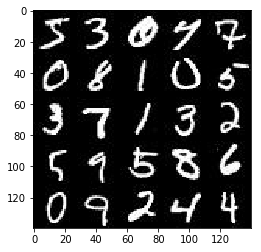

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

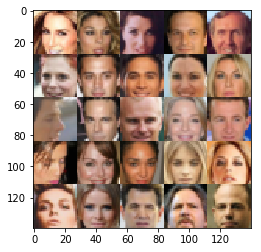

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


E:\Anaconda3\envs\tf1p1\lib\site-packages\ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(dtype= tf.float32, shape=[None, image_width, image_height, image_channels], name =
                                'input_real')
    input_z  = tf.placeholder(dtype= tf.float32, shape=[None, z_dim], name = 'input_z')
    input_lr = tf.placeholder(dtype= tf.float32, name= 'learn_rate')
    return input_real, input_z, input_lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    
    # Introdce noise to improve generalization
    dropout_keep_prob = 0.1
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * x1, x1)
        relu1 = tf.layers.dropout(relu1, dropout_keep_prob, training=True)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        relu2 = tf.layers.dropout(relu2, dropout_keep_prob, training=True)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        relu3 = tf.layers.dropout(relu3, dropout_keep_prob, training=True)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    # Introdce noise to improve generalization
    dropout_keep_prob = 0.1
    
    with tf.variable_scope('generator', reuse=(not is_train)):
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.layers.dropout(x1, dropout_keep_prob, training=is_train)
        #print(x1.get_shape())
        # 2x2x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 3, strides=2, padding='same',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.layers.dropout(x2, dropout_keep_prob, training=is_train)
        #print(x2.get_shape())
        # 4x4x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=3, padding='valid',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.layers.dropout(x3, dropout_keep_prob, training=is_train)
        #print(x3.get_shape())
        # 14x14x128
        
        #print(out_channel_dim)
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same',
                                           kernel_initializer=tf.contrib.layers.xavier_initializer())
        #print(logits.get_shape())
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    smooth = 0.1
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=(1 - smooth) * tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    #print('UPDATE_OPS:', tf.get_collection(tf.GraphKeys.UPDATE_OPS))
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
   
    #print('data_shape:', data_shape)
    input_real, input_z, lr = model_inputs(data_shape[-3], data_shape[-2], data_shape[-1], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[-1])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                if steps % 100 == 0: 
                    show_generator_output(sess, 25, input_z, data_shape[-1], data_image_mode)                
                
                    
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [12]:
tf.reset_default_graph()

Epoch 1/2... Discriminator Loss: 0.6266... Generator Loss: 1.8840
Epoch 1/2... Discriminator Loss: 0.5229... Generator Loss: 2.3122
Epoch 1/2... Discriminator Loss: 0.6206... Generator Loss: 1.7324
Epoch 1/2... Discriminator Loss: 0.5981... Generator Loss: 2.0962
Epoch 1/2... Discriminator Loss: 0.8918... Generator Loss: 2.2407
Epoch 1/2... Discriminator Loss: 1.2143... Generator Loss: 0.9362
Epoch 1/2... Discriminator Loss: 0.7299... Generator Loss: 2.1988
Epoch 1/2... Discriminator Loss: 0.6814... Generator Loss: 2.0232
Epoch 1/2... Discriminator Loss: 0.7212... Generator Loss: 1.9572
Epoch 1/2... Discriminator Loss: 0.6012... Generator Loss: 2.2108


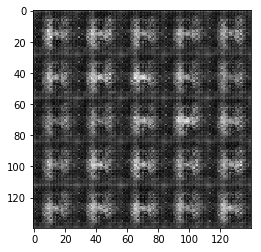

Epoch 1/2... Discriminator Loss: 0.5203... Generator Loss: 3.4108
Epoch 1/2... Discriminator Loss: 0.6309... Generator Loss: 2.6353
Epoch 1/2... Discriminator Loss: 0.5222... Generator Loss: 2.7275
Epoch 1/2... Discriminator Loss: 0.7129... Generator Loss: 1.7607
Epoch 1/2... Discriminator Loss: 0.4376... Generator Loss: 3.3907
Epoch 1/2... Discriminator Loss: 0.6710... Generator Loss: 2.4518
Epoch 1/2... Discriminator Loss: 0.5735... Generator Loss: 2.8131
Epoch 1/2... Discriminator Loss: 0.6084... Generator Loss: 2.4910
Epoch 1/2... Discriminator Loss: 0.5018... Generator Loss: 3.2780
Epoch 1/2... Discriminator Loss: 0.4266... Generator Loss: 3.9319


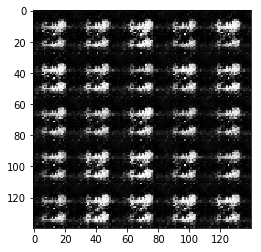

Epoch 1/2... Discriminator Loss: 0.6678... Generator Loss: 1.9897
Epoch 1/2... Discriminator Loss: 0.4972... Generator Loss: 3.5844
Epoch 1/2... Discriminator Loss: 0.4705... Generator Loss: 3.4426
Epoch 1/2... Discriminator Loss: 0.5703... Generator Loss: 2.8036
Epoch 1/2... Discriminator Loss: 0.4706... Generator Loss: 2.9459
Epoch 1/2... Discriminator Loss: 0.4765... Generator Loss: 3.4559
Epoch 1/2... Discriminator Loss: 0.5061... Generator Loss: 3.9777
Epoch 1/2... Discriminator Loss: 0.5183... Generator Loss: 3.4033
Epoch 1/2... Discriminator Loss: 0.5412... Generator Loss: 2.4674
Epoch 1/2... Discriminator Loss: 0.5081... Generator Loss: 3.7962


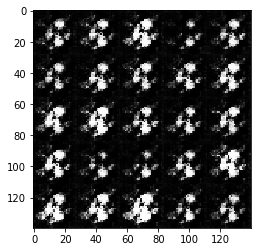

Epoch 1/2... Discriminator Loss: 0.4760... Generator Loss: 3.0434
Epoch 1/2... Discriminator Loss: 0.4821... Generator Loss: 3.2651
Epoch 1/2... Discriminator Loss: 0.4870... Generator Loss: 2.9747
Epoch 1/2... Discriminator Loss: 0.4524... Generator Loss: 2.9568
Epoch 1/2... Discriminator Loss: 0.4549... Generator Loss: 3.7959
Epoch 1/2... Discriminator Loss: 0.6084... Generator Loss: 3.3180
Epoch 1/2... Discriminator Loss: 0.4557... Generator Loss: 3.5299
Epoch 1/2... Discriminator Loss: 0.4216... Generator Loss: 3.6135
Epoch 1/2... Discriminator Loss: 0.4255... Generator Loss: 3.6503
Epoch 1/2... Discriminator Loss: 0.4031... Generator Loss: 4.3104


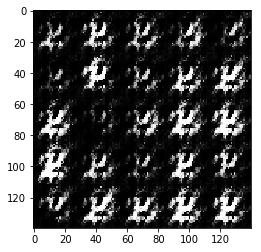

Epoch 1/2... Discriminator Loss: 0.4184... Generator Loss: 3.8886
Epoch 1/2... Discriminator Loss: 0.4762... Generator Loss: 3.7428
Epoch 1/2... Discriminator Loss: 0.5230... Generator Loss: 2.4251
Epoch 1/2... Discriminator Loss: 0.4693... Generator Loss: 3.8404
Epoch 1/2... Discriminator Loss: 0.4366... Generator Loss: 3.4980
Epoch 1/2... Discriminator Loss: 0.4942... Generator Loss: 2.7936
Epoch 1/2... Discriminator Loss: 0.4500... Generator Loss: 4.8412
Epoch 1/2... Discriminator Loss: 0.5089... Generator Loss: 2.9055
Epoch 1/2... Discriminator Loss: 0.4908... Generator Loss: 4.2067
Epoch 1/2... Discriminator Loss: 0.4755... Generator Loss: 3.2110


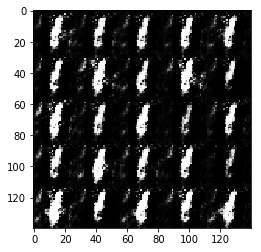

Epoch 1/2... Discriminator Loss: 0.4238... Generator Loss: 4.0562
Epoch 1/2... Discriminator Loss: 0.4541... Generator Loss: 3.5766
Epoch 1/2... Discriminator Loss: 0.4091... Generator Loss: 3.9602
Epoch 1/2... Discriminator Loss: 0.3945... Generator Loss: 4.8246
Epoch 1/2... Discriminator Loss: 0.3982... Generator Loss: 4.4824
Epoch 1/2... Discriminator Loss: 0.3853... Generator Loss: 4.4704
Epoch 1/2... Discriminator Loss: 0.3809... Generator Loss: 4.4577
Epoch 1/2... Discriminator Loss: 0.3618... Generator Loss: 4.6747
Epoch 1/2... Discriminator Loss: 0.4082... Generator Loss: 4.6336
Epoch 1/2... Discriminator Loss: 0.4221... Generator Loss: 4.4647


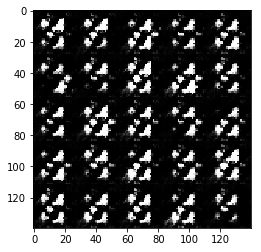

Epoch 1/2... Discriminator Loss: 0.4231... Generator Loss: 4.6001
Epoch 1/2... Discriminator Loss: 0.4194... Generator Loss: 4.4186
Epoch 1/2... Discriminator Loss: 0.4144... Generator Loss: 3.9539
Epoch 1/2... Discriminator Loss: 0.4374... Generator Loss: 4.7409
Epoch 1/2... Discriminator Loss: 0.4300... Generator Loss: 3.2336
Epoch 1/2... Discriminator Loss: 0.4500... Generator Loss: 2.9125
Epoch 1/2... Discriminator Loss: 0.4625... Generator Loss: 3.6350
Epoch 1/2... Discriminator Loss: 0.3939... Generator Loss: 4.1386
Epoch 1/2... Discriminator Loss: 0.4343... Generator Loss: 3.3859
Epoch 1/2... Discriminator Loss: 0.4539... Generator Loss: 2.9692


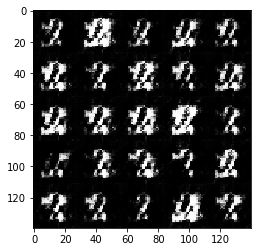

Epoch 1/2... Discriminator Loss: 0.5008... Generator Loss: 2.6775
Epoch 1/2... Discriminator Loss: 0.4522... Generator Loss: 3.9467
Epoch 1/2... Discriminator Loss: 0.4716... Generator Loss: 3.6560
Epoch 1/2... Discriminator Loss: 0.4605... Generator Loss: 2.7572
Epoch 1/2... Discriminator Loss: 0.5493... Generator Loss: 2.2372
Epoch 1/2... Discriminator Loss: 0.6679... Generator Loss: 4.8892
Epoch 1/2... Discriminator Loss: 0.4917... Generator Loss: 3.0211
Epoch 1/2... Discriminator Loss: 0.5768... Generator Loss: 2.6554
Epoch 1/2... Discriminator Loss: 0.5097... Generator Loss: 2.6185
Epoch 1/2... Discriminator Loss: 0.6540... Generator Loss: 1.8225


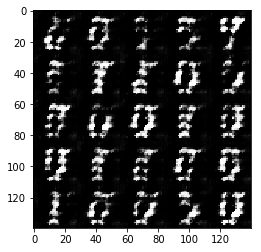

Epoch 1/2... Discriminator Loss: 0.5387... Generator Loss: 2.7507
Epoch 1/2... Discriminator Loss: 0.6521... Generator Loss: 3.7482
Epoch 1/2... Discriminator Loss: 0.4827... Generator Loss: 3.7398
Epoch 1/2... Discriminator Loss: 0.5874... Generator Loss: 2.2263
Epoch 1/2... Discriminator Loss: 0.4652... Generator Loss: 3.8138
Epoch 1/2... Discriminator Loss: 0.5635... Generator Loss: 2.4140
Epoch 1/2... Discriminator Loss: 0.4573... Generator Loss: 3.6884
Epoch 1/2... Discriminator Loss: 0.6085... Generator Loss: 2.2046
Epoch 1/2... Discriminator Loss: 0.5128... Generator Loss: 3.3888
Epoch 1/2... Discriminator Loss: 0.4712... Generator Loss: 3.5894


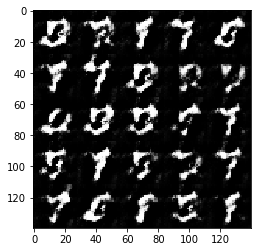

Epoch 1/2... Discriminator Loss: 0.4294... Generator Loss: 3.3306
Epoch 1/2... Discriminator Loss: 0.4931... Generator Loss: 3.2059
Epoch 1/2... Discriminator Loss: 0.4863... Generator Loss: 2.8911
Epoch 1/2... Discriminator Loss: 0.5739... Generator Loss: 2.2423
Epoch 1/2... Discriminator Loss: 0.5335... Generator Loss: 3.1609
Epoch 1/2... Discriminator Loss: 0.4676... Generator Loss: 3.2189
Epoch 1/2... Discriminator Loss: 0.4951... Generator Loss: 4.0272
Epoch 1/2... Discriminator Loss: 0.5054... Generator Loss: 2.8536
Epoch 1/2... Discriminator Loss: 0.5575... Generator Loss: 3.0924
Epoch 1/2... Discriminator Loss: 0.5061... Generator Loss: 2.4485


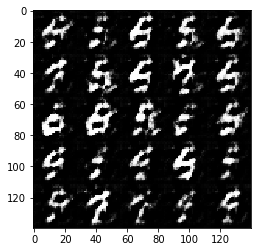

Epoch 1/2... Discriminator Loss: 0.5648... Generator Loss: 2.8212
Epoch 1/2... Discriminator Loss: 0.4953... Generator Loss: 3.2610
Epoch 1/2... Discriminator Loss: 0.5764... Generator Loss: 2.8250
Epoch 1/2... Discriminator Loss: 0.5828... Generator Loss: 3.2176
Epoch 1/2... Discriminator Loss: 0.4575... Generator Loss: 4.2647
Epoch 1/2... Discriminator Loss: 0.4790... Generator Loss: 4.0447
Epoch 1/2... Discriminator Loss: 0.4882... Generator Loss: 2.9041
Epoch 1/2... Discriminator Loss: 0.5139... Generator Loss: 3.1262
Epoch 1/2... Discriminator Loss: 0.5667... Generator Loss: 2.3553
Epoch 1/2... Discriminator Loss: 0.5894... Generator Loss: 2.8955


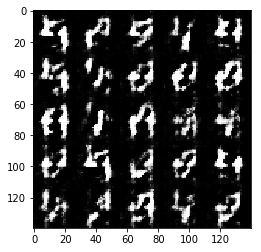

Epoch 1/2... Discriminator Loss: 0.6800... Generator Loss: 2.0167
Epoch 1/2... Discriminator Loss: 0.6662... Generator Loss: 3.1901
Epoch 1/2... Discriminator Loss: 0.6035... Generator Loss: 2.3773
Epoch 1/2... Discriminator Loss: 0.5935... Generator Loss: 2.7453
Epoch 1/2... Discriminator Loss: 0.5345... Generator Loss: 3.6197
Epoch 1/2... Discriminator Loss: 0.5267... Generator Loss: 2.8866
Epoch 1/2... Discriminator Loss: 0.4849... Generator Loss: 3.2375
Epoch 1/2... Discriminator Loss: 0.5154... Generator Loss: 3.2831
Epoch 1/2... Discriminator Loss: 0.5504... Generator Loss: 2.4010
Epoch 1/2... Discriminator Loss: 1.1779... Generator Loss: 0.9620


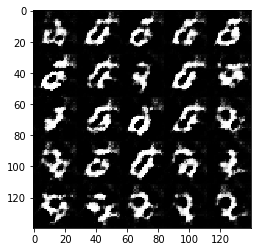

Epoch 1/2... Discriminator Loss: 0.8148... Generator Loss: 1.6900
Epoch 1/2... Discriminator Loss: 0.5775... Generator Loss: 3.3888
Epoch 1/2... Discriminator Loss: 0.6626... Generator Loss: 2.2307
Epoch 1/2... Discriminator Loss: 0.5035... Generator Loss: 2.7521
Epoch 1/2... Discriminator Loss: 0.5791... Generator Loss: 3.2674
Epoch 1/2... Discriminator Loss: 0.8247... Generator Loss: 3.8200
Epoch 1/2... Discriminator Loss: 0.4464... Generator Loss: 2.9441
Epoch 1/2... Discriminator Loss: 0.4761... Generator Loss: 3.4074
Epoch 1/2... Discriminator Loss: 0.4981... Generator Loss: 2.9161
Epoch 1/2... Discriminator Loss: 0.8273... Generator Loss: 2.3012


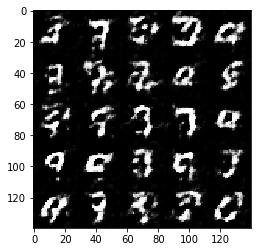

Epoch 1/2... Discriminator Loss: 0.5347... Generator Loss: 3.2763
Epoch 1/2... Discriminator Loss: 0.5815... Generator Loss: 2.3418
Epoch 1/2... Discriminator Loss: 0.6704... Generator Loss: 1.9958
Epoch 1/2... Discriminator Loss: 0.5967... Generator Loss: 3.0447
Epoch 1/2... Discriminator Loss: 0.5266... Generator Loss: 2.6684
Epoch 1/2... Discriminator Loss: 1.1091... Generator Loss: 0.9522
Epoch 1/2... Discriminator Loss: 0.5745... Generator Loss: 3.2268
Epoch 1/2... Discriminator Loss: 0.6566... Generator Loss: 1.8897
Epoch 1/2... Discriminator Loss: 0.5865... Generator Loss: 2.5177
Epoch 1/2... Discriminator Loss: 0.4791... Generator Loss: 2.9258


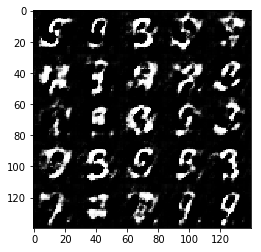

Epoch 1/2... Discriminator Loss: 0.5200... Generator Loss: 3.1270
Epoch 1/2... Discriminator Loss: 0.5412... Generator Loss: 3.2041
Epoch 1/2... Discriminator Loss: 0.7181... Generator Loss: 1.7989
Epoch 1/2... Discriminator Loss: 0.4982... Generator Loss: 2.7448
Epoch 1/2... Discriminator Loss: 0.5535... Generator Loss: 2.7160
Epoch 1/2... Discriminator Loss: 0.5468... Generator Loss: 2.7569
Epoch 1/2... Discriminator Loss: 0.6244... Generator Loss: 2.7102
Epoch 1/2... Discriminator Loss: 0.5154... Generator Loss: 2.5578
Epoch 1/2... Discriminator Loss: 0.6633... Generator Loss: 2.8523
Epoch 1/2... Discriminator Loss: 0.5518... Generator Loss: 3.5020


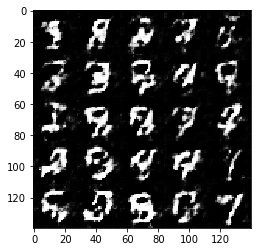

Epoch 1/2... Discriminator Loss: 0.6530... Generator Loss: 2.3184
Epoch 1/2... Discriminator Loss: 0.7370... Generator Loss: 3.3404
Epoch 1/2... Discriminator Loss: 0.5931... Generator Loss: 2.4024
Epoch 1/2... Discriminator Loss: 0.5875... Generator Loss: 2.1825
Epoch 1/2... Discriminator Loss: 0.6281... Generator Loss: 2.4993
Epoch 1/2... Discriminator Loss: 0.6969... Generator Loss: 1.9160
Epoch 1/2... Discriminator Loss: 1.3477... Generator Loss: 5.4983
Epoch 1/2... Discriminator Loss: 0.6138... Generator Loss: 3.6157
Epoch 1/2... Discriminator Loss: 0.6104... Generator Loss: 3.1893
Epoch 1/2... Discriminator Loss: 0.6823... Generator Loss: 2.0798


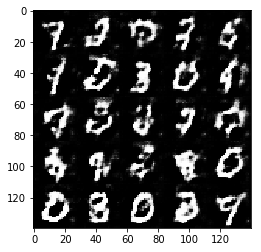

Epoch 1/2... Discriminator Loss: 0.7874... Generator Loss: 3.7092
Epoch 1/2... Discriminator Loss: 0.6321... Generator Loss: 1.9200
Epoch 1/2... Discriminator Loss: 0.7585... Generator Loss: 1.5536
Epoch 1/2... Discriminator Loss: 0.6853... Generator Loss: 2.0373
Epoch 1/2... Discriminator Loss: 0.8052... Generator Loss: 1.6773
Epoch 1/2... Discriminator Loss: 0.5738... Generator Loss: 2.1700
Epoch 1/2... Discriminator Loss: 0.6551... Generator Loss: 2.0697
Epoch 1/2... Discriminator Loss: 0.5205... Generator Loss: 3.0337
Epoch 1/2... Discriminator Loss: 0.6389... Generator Loss: 2.4147
Epoch 1/2... Discriminator Loss: 1.4335... Generator Loss: 0.8932


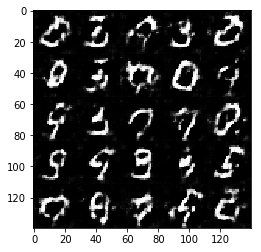

Epoch 1/2... Discriminator Loss: 0.7578... Generator Loss: 1.8539
Epoch 1/2... Discriminator Loss: 0.8791... Generator Loss: 1.9395
Epoch 1/2... Discriminator Loss: 0.7455... Generator Loss: 1.6879
Epoch 1/2... Discriminator Loss: 0.7711... Generator Loss: 1.5637
Epoch 1/2... Discriminator Loss: 0.6403... Generator Loss: 3.3205
Epoch 1/2... Discriminator Loss: 0.4820... Generator Loss: 2.7416
Epoch 1/2... Discriminator Loss: 0.7520... Generator Loss: 1.8135
Epoch 1/2... Discriminator Loss: 0.5252... Generator Loss: 2.8985
Epoch 1/2... Discriminator Loss: 0.6594... Generator Loss: 2.0820
Epoch 1/2... Discriminator Loss: 0.5707... Generator Loss: 2.1795


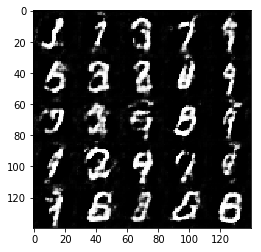

Epoch 1/2... Discriminator Loss: 0.8728... Generator Loss: 1.4465
Epoch 1/2... Discriminator Loss: 0.6994... Generator Loss: 2.9639
Epoch 1/2... Discriminator Loss: 0.7722... Generator Loss: 1.5771
Epoch 1/2... Discriminator Loss: 0.5618... Generator Loss: 2.1251
Epoch 1/2... Discriminator Loss: 0.8890... Generator Loss: 1.5703
Epoch 1/2... Discriminator Loss: 0.6720... Generator Loss: 1.7196
Epoch 1/2... Discriminator Loss: 0.5462... Generator Loss: 2.4031
Epoch 2/2... Discriminator Loss: 0.5796... Generator Loss: 2.7742
Epoch 2/2... Discriminator Loss: 0.7552... Generator Loss: 1.6244
Epoch 2/2... Discriminator Loss: 0.5172... Generator Loss: 2.8371


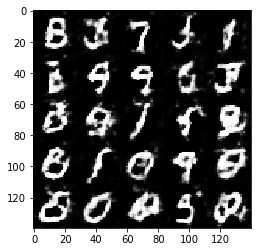

Epoch 2/2... Discriminator Loss: 0.7486... Generator Loss: 2.1047
Epoch 2/2... Discriminator Loss: 0.6346... Generator Loss: 1.9182
Epoch 2/2... Discriminator Loss: 0.9077... Generator Loss: 1.3820
Epoch 2/2... Discriminator Loss: 0.7207... Generator Loss: 1.9649
Epoch 2/2... Discriminator Loss: 1.0452... Generator Loss: 2.8966
Epoch 2/2... Discriminator Loss: 0.7515... Generator Loss: 2.6094
Epoch 2/2... Discriminator Loss: 0.6454... Generator Loss: 1.8383
Epoch 2/2... Discriminator Loss: 0.8667... Generator Loss: 1.4919
Epoch 2/2... Discriminator Loss: 0.6194... Generator Loss: 2.4903
Epoch 2/2... Discriminator Loss: 0.7984... Generator Loss: 1.5216


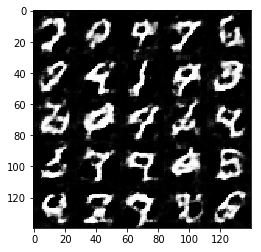

Epoch 2/2... Discriminator Loss: 0.6344... Generator Loss: 2.1873
Epoch 2/2... Discriminator Loss: 0.7066... Generator Loss: 2.8131
Epoch 2/2... Discriminator Loss: 0.6136... Generator Loss: 2.3394
Epoch 2/2... Discriminator Loss: 0.6644... Generator Loss: 2.4636
Epoch 2/2... Discriminator Loss: 0.7385... Generator Loss: 1.8139
Epoch 2/2... Discriminator Loss: 0.7664... Generator Loss: 2.0303
Epoch 2/2... Discriminator Loss: 0.6379... Generator Loss: 1.9017
Epoch 2/2... Discriminator Loss: 0.6317... Generator Loss: 1.8789
Epoch 2/2... Discriminator Loss: 0.6982... Generator Loss: 2.2244
Epoch 2/2... Discriminator Loss: 0.6810... Generator Loss: 2.0250


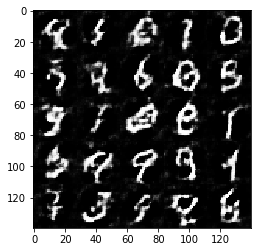

Epoch 2/2... Discriminator Loss: 0.6657... Generator Loss: 1.6291
Epoch 2/2... Discriminator Loss: 0.6894... Generator Loss: 1.8044
Epoch 2/2... Discriminator Loss: 0.5742... Generator Loss: 1.9266
Epoch 2/2... Discriminator Loss: 0.6628... Generator Loss: 2.5180
Epoch 2/2... Discriminator Loss: 1.1282... Generator Loss: 0.9211
Epoch 2/2... Discriminator Loss: 1.2258... Generator Loss: 3.4146
Epoch 2/2... Discriminator Loss: 0.7307... Generator Loss: 1.5363
Epoch 2/2... Discriminator Loss: 0.7965... Generator Loss: 2.8243
Epoch 2/2... Discriminator Loss: 0.5602... Generator Loss: 2.3893
Epoch 2/2... Discriminator Loss: 0.7533... Generator Loss: 1.2593


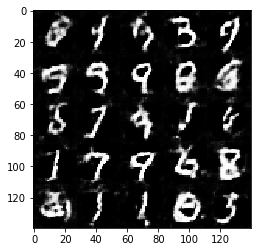

Epoch 2/2... Discriminator Loss: 0.9341... Generator Loss: 1.4641
Epoch 2/2... Discriminator Loss: 0.5394... Generator Loss: 2.9970
Epoch 2/2... Discriminator Loss: 0.7542... Generator Loss: 2.8623
Epoch 2/2... Discriminator Loss: 0.7009... Generator Loss: 2.6606
Epoch 2/2... Discriminator Loss: 0.6457... Generator Loss: 1.6969
Epoch 2/2... Discriminator Loss: 0.7031... Generator Loss: 2.0130
Epoch 2/2... Discriminator Loss: 0.7156... Generator Loss: 2.5567
Epoch 2/2... Discriminator Loss: 0.6058... Generator Loss: 1.9904
Epoch 2/2... Discriminator Loss: 0.7104... Generator Loss: 1.4615
Epoch 2/2... Discriminator Loss: 0.6799... Generator Loss: 2.0342


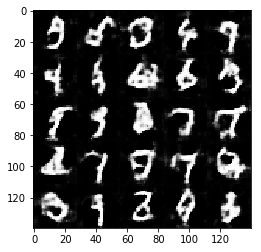

Epoch 2/2... Discriminator Loss: 0.6718... Generator Loss: 2.0128
Epoch 2/2... Discriminator Loss: 0.8193... Generator Loss: 1.6740
Epoch 2/2... Discriminator Loss: 0.7066... Generator Loss: 1.6038
Epoch 2/2... Discriminator Loss: 0.7493... Generator Loss: 1.6979
Epoch 2/2... Discriminator Loss: 0.7253... Generator Loss: 2.3683
Epoch 2/2... Discriminator Loss: 0.7053... Generator Loss: 1.2817
Epoch 2/2... Discriminator Loss: 0.6549... Generator Loss: 2.1483
Epoch 2/2... Discriminator Loss: 0.7763... Generator Loss: 1.6719
Epoch 2/2... Discriminator Loss: 0.6079... Generator Loss: 2.2985
Epoch 2/2... Discriminator Loss: 0.6389... Generator Loss: 2.0220


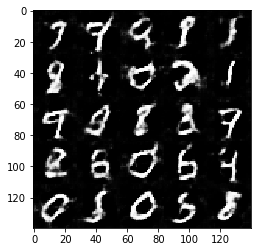

Epoch 2/2... Discriminator Loss: 0.7404... Generator Loss: 1.7943
Epoch 2/2... Discriminator Loss: 0.5400... Generator Loss: 2.0590
Epoch 2/2... Discriminator Loss: 0.8005... Generator Loss: 1.3117
Epoch 2/2... Discriminator Loss: 0.6695... Generator Loss: 1.7438
Epoch 2/2... Discriminator Loss: 0.5962... Generator Loss: 2.0223
Epoch 2/2... Discriminator Loss: 0.6971... Generator Loss: 1.7226
Epoch 2/2... Discriminator Loss: 0.9141... Generator Loss: 2.2565
Epoch 2/2... Discriminator Loss: 0.6761... Generator Loss: 1.5871
Epoch 2/2... Discriminator Loss: 0.5656... Generator Loss: 2.3845
Epoch 2/2... Discriminator Loss: 0.7337... Generator Loss: 1.7836


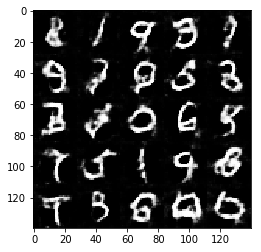

Epoch 2/2... Discriminator Loss: 1.0546... Generator Loss: 1.5302
Epoch 2/2... Discriminator Loss: 0.8962... Generator Loss: 2.5286
Epoch 2/2... Discriminator Loss: 0.5517... Generator Loss: 2.9185
Epoch 2/2... Discriminator Loss: 0.8747... Generator Loss: 2.1395
Epoch 2/2... Discriminator Loss: 0.8729... Generator Loss: 1.6051
Epoch 2/2... Discriminator Loss: 0.5486... Generator Loss: 2.3585
Epoch 2/2... Discriminator Loss: 0.7842... Generator Loss: 2.4541
Epoch 2/2... Discriminator Loss: 0.6713... Generator Loss: 1.8464
Epoch 2/2... Discriminator Loss: 0.6569... Generator Loss: 2.6092
Epoch 2/2... Discriminator Loss: 0.7841... Generator Loss: 2.0773


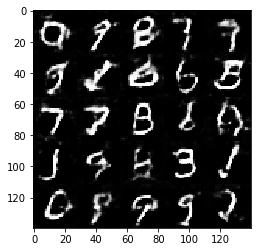

Epoch 2/2... Discriminator Loss: 0.9612... Generator Loss: 1.2533
Epoch 2/2... Discriminator Loss: 0.6006... Generator Loss: 2.2305
Epoch 2/2... Discriminator Loss: 0.7956... Generator Loss: 1.1939
Epoch 2/2... Discriminator Loss: 0.7923... Generator Loss: 1.6765
Epoch 2/2... Discriminator Loss: 0.8244... Generator Loss: 1.7029
Epoch 2/2... Discriminator Loss: 0.7433... Generator Loss: 1.8801
Epoch 2/2... Discriminator Loss: 0.8789... Generator Loss: 1.3396
Epoch 2/2... Discriminator Loss: 0.8270... Generator Loss: 2.0550
Epoch 2/2... Discriminator Loss: 0.5858... Generator Loss: 2.7709
Epoch 2/2... Discriminator Loss: 1.2416... Generator Loss: 2.9628


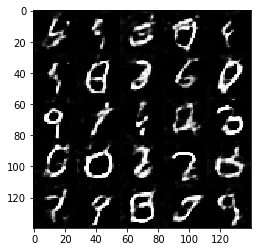

Epoch 2/2... Discriminator Loss: 0.8382... Generator Loss: 2.7310
Epoch 2/2... Discriminator Loss: 0.8656... Generator Loss: 1.9197
Epoch 2/2... Discriminator Loss: 0.9388... Generator Loss: 1.4715
Epoch 2/2... Discriminator Loss: 0.8044... Generator Loss: 1.8922
Epoch 2/2... Discriminator Loss: 0.7528... Generator Loss: 2.1520
Epoch 2/2... Discriminator Loss: 0.6323... Generator Loss: 2.4465
Epoch 2/2... Discriminator Loss: 0.8442... Generator Loss: 2.8292
Epoch 2/2... Discriminator Loss: 0.5291... Generator Loss: 2.6867
Epoch 2/2... Discriminator Loss: 0.7829... Generator Loss: 1.8655
Epoch 2/2... Discriminator Loss: 0.9295... Generator Loss: 1.3410


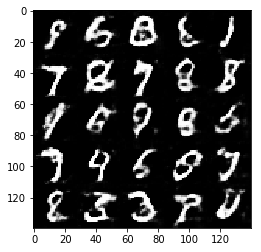

Epoch 2/2... Discriminator Loss: 0.7654... Generator Loss: 1.9216
Epoch 2/2... Discriminator Loss: 0.8185... Generator Loss: 2.4567
Epoch 2/2... Discriminator Loss: 0.7291... Generator Loss: 2.3857
Epoch 2/2... Discriminator Loss: 0.8095... Generator Loss: 2.2034
Epoch 2/2... Discriminator Loss: 0.7769... Generator Loss: 1.9893
Epoch 2/2... Discriminator Loss: 0.6775... Generator Loss: 2.5457
Epoch 2/2... Discriminator Loss: 0.7083... Generator Loss: 2.0871
Epoch 2/2... Discriminator Loss: 0.7859... Generator Loss: 2.4699
Epoch 2/2... Discriminator Loss: 0.7188... Generator Loss: 1.8667
Epoch 2/2... Discriminator Loss: 0.7642... Generator Loss: 1.4593


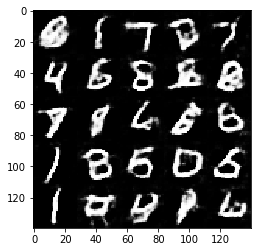

Epoch 2/2... Discriminator Loss: 0.5477... Generator Loss: 2.6143
Epoch 2/2... Discriminator Loss: 0.7712... Generator Loss: 1.5456
Epoch 2/2... Discriminator Loss: 0.6344... Generator Loss: 2.1187
Epoch 2/2... Discriminator Loss: 0.6205... Generator Loss: 1.9638
Epoch 2/2... Discriminator Loss: 0.8584... Generator Loss: 2.7789
Epoch 2/2... Discriminator Loss: 0.7549... Generator Loss: 1.7928
Epoch 2/2... Discriminator Loss: 0.7135... Generator Loss: 1.5937
Epoch 2/2... Discriminator Loss: 0.6209... Generator Loss: 2.1077
Epoch 2/2... Discriminator Loss: 0.6449... Generator Loss: 1.9996
Epoch 2/2... Discriminator Loss: 0.6965... Generator Loss: 1.6701


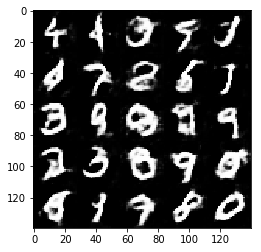

Epoch 2/2... Discriminator Loss: 1.1775... Generator Loss: 0.8073
Epoch 2/2... Discriminator Loss: 0.8050... Generator Loss: 2.6629
Epoch 2/2... Discriminator Loss: 0.7866... Generator Loss: 1.4252
Epoch 2/2... Discriminator Loss: 0.8073... Generator Loss: 1.5759
Epoch 2/2... Discriminator Loss: 0.7107... Generator Loss: 2.1739
Epoch 2/2... Discriminator Loss: 0.6880... Generator Loss: 2.8418
Epoch 2/2... Discriminator Loss: 0.6056... Generator Loss: 2.2448
Epoch 2/2... Discriminator Loss: 0.8761... Generator Loss: 1.3996
Epoch 2/2... Discriminator Loss: 0.8384... Generator Loss: 1.7243
Epoch 2/2... Discriminator Loss: 0.9715... Generator Loss: 1.3329


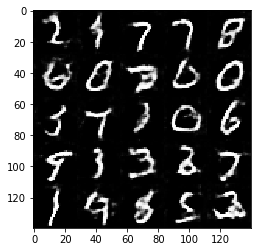

Epoch 2/2... Discriminator Loss: 0.7353... Generator Loss: 2.5520
Epoch 2/2... Discriminator Loss: 0.6516... Generator Loss: 1.9295
Epoch 2/2... Discriminator Loss: 1.0237... Generator Loss: 0.7630
Epoch 2/2... Discriminator Loss: 0.9046... Generator Loss: 1.3156
Epoch 2/2... Discriminator Loss: 0.6778... Generator Loss: 2.1829
Epoch 2/2... Discriminator Loss: 0.7191... Generator Loss: 1.8278
Epoch 2/2... Discriminator Loss: 0.7410... Generator Loss: 2.2208
Epoch 2/2... Discriminator Loss: 0.8515... Generator Loss: 1.5490
Epoch 2/2... Discriminator Loss: 0.7647... Generator Loss: 1.8753
Epoch 2/2... Discriminator Loss: 0.9024... Generator Loss: 1.6397


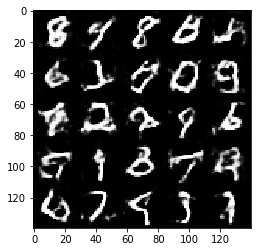

Epoch 2/2... Discriminator Loss: 0.7156... Generator Loss: 1.9986
Epoch 2/2... Discriminator Loss: 0.8050... Generator Loss: 1.6289
Epoch 2/2... Discriminator Loss: 0.8142... Generator Loss: 1.5109
Epoch 2/2... Discriminator Loss: 0.8405... Generator Loss: 2.5892
Epoch 2/2... Discriminator Loss: 0.6481... Generator Loss: 2.1453
Epoch 2/2... Discriminator Loss: 0.6743... Generator Loss: 1.9325
Epoch 2/2... Discriminator Loss: 0.7319... Generator Loss: 2.3394
Epoch 2/2... Discriminator Loss: 1.0497... Generator Loss: 2.3987
Epoch 2/2... Discriminator Loss: 1.0242... Generator Loss: 1.2193
Epoch 2/2... Discriminator Loss: 0.6393... Generator Loss: 2.0395


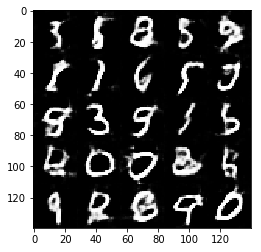

Epoch 2/2... Discriminator Loss: 0.6814... Generator Loss: 1.9993
Epoch 2/2... Discriminator Loss: 0.7657... Generator Loss: 1.3458
Epoch 2/2... Discriminator Loss: 0.6954... Generator Loss: 1.5524
Epoch 2/2... Discriminator Loss: 0.5661... Generator Loss: 2.5949
Epoch 2/2... Discriminator Loss: 0.8858... Generator Loss: 1.1520
Epoch 2/2... Discriminator Loss: 0.7014... Generator Loss: 2.0520
Epoch 2/2... Discriminator Loss: 1.0815... Generator Loss: 1.2175
Epoch 2/2... Discriminator Loss: 0.7932... Generator Loss: 1.8559
Epoch 2/2... Discriminator Loss: 0.7578... Generator Loss: 3.3894
Epoch 2/2... Discriminator Loss: 0.7736... Generator Loss: 1.7732


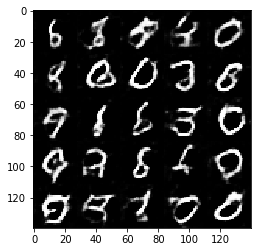

Epoch 2/2... Discriminator Loss: 0.8798... Generator Loss: 2.8175
Epoch 2/2... Discriminator Loss: 0.8480... Generator Loss: 1.6203
Epoch 2/2... Discriminator Loss: 0.9017... Generator Loss: 1.0983
Epoch 2/2... Discriminator Loss: 0.7968... Generator Loss: 1.4667
Epoch 2/2... Discriminator Loss: 0.9287... Generator Loss: 1.2812
Epoch 2/2... Discriminator Loss: 0.7674... Generator Loss: 1.3739
Epoch 2/2... Discriminator Loss: 0.8494... Generator Loss: 2.7724
Epoch 2/2... Discriminator Loss: 0.8665... Generator Loss: 1.5202
Epoch 2/2... Discriminator Loss: 0.9110... Generator Loss: 1.5220
Epoch 2/2... Discriminator Loss: 0.6789... Generator Loss: 2.0617


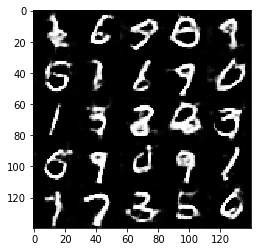

Epoch 2/2... Discriminator Loss: 0.5688... Generator Loss: 2.1619
Epoch 2/2... Discriminator Loss: 0.6948... Generator Loss: 2.4558
Epoch 2/2... Discriminator Loss: 0.7815... Generator Loss: 2.1029
Epoch 2/2... Discriminator Loss: 0.6219... Generator Loss: 2.6682
Epoch 2/2... Discriminator Loss: 0.6629... Generator Loss: 1.7714
Epoch 2/2... Discriminator Loss: 0.7485... Generator Loss: 1.4684
Epoch 2/2... Discriminator Loss: 1.0382... Generator Loss: 1.2635
Epoch 2/2... Discriminator Loss: 0.6266... Generator Loss: 2.4160
Epoch 2/2... Discriminator Loss: 0.9411... Generator Loss: 1.4453
Epoch 2/2... Discriminator Loss: 0.7010... Generator Loss: 2.0286


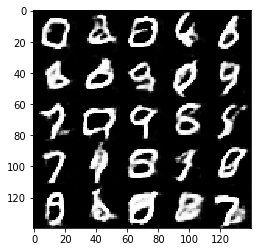

Epoch 2/2... Discriminator Loss: 0.4696... Generator Loss: 3.4908
Epoch 2/2... Discriminator Loss: 0.8063... Generator Loss: 1.9351
Epoch 2/2... Discriminator Loss: 0.6030... Generator Loss: 1.8913
Epoch 2/2... Discriminator Loss: 0.7291... Generator Loss: 1.9793
Epoch 2/2... Discriminator Loss: 0.7524... Generator Loss: 2.3942
Epoch 2/2... Discriminator Loss: 0.6916... Generator Loss: 1.7073
Epoch 2/2... Discriminator Loss: 0.8547... Generator Loss: 1.4587
Epoch 2/2... Discriminator Loss: 0.6934... Generator Loss: 1.4404
Epoch 2/2... Discriminator Loss: 0.7193... Generator Loss: 2.1078
Epoch 2/2... Discriminator Loss: 0.7760... Generator Loss: 1.4445


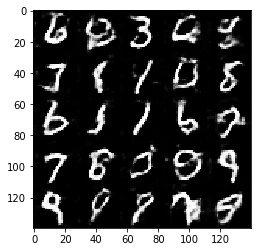

Epoch 2/2... Discriminator Loss: 0.6989... Generator Loss: 2.4450
Epoch 2/2... Discriminator Loss: 0.5862... Generator Loss: 2.4219
Epoch 2/2... Discriminator Loss: 0.7619... Generator Loss: 1.6384
Epoch 2/2... Discriminator Loss: 0.7482... Generator Loss: 1.4730
Epoch 2/2... Discriminator Loss: 0.5589... Generator Loss: 2.7174


In [13]:
batch_size = 32
z_dim = 96
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, 
          mnist_dataset.get_batches,
          mnist_dataset.shape, 
          mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.8437... Generator Loss: 1.1145
Epoch 1/1... Discriminator Loss: 0.5706... Generator Loss: 2.2572
Epoch 1/1... Discriminator Loss: 0.6716... Generator Loss: 2.4628
Epoch 1/1... Discriminator Loss: 0.5688... Generator Loss: 5.8725
Epoch 1/1... Discriminator Loss: 0.4071... Generator Loss: 4.0835
Epoch 1/1... Discriminator Loss: 0.4519... Generator Loss: 3.8254
Epoch 1/1... Discriminator Loss: 0.3678... Generator Loss: 7.8267
Epoch 1/1... Discriminator Loss: 0.3993... Generator Loss: 6.1151
Epoch 1/1... Discriminator Loss: 0.8944... Generator Loss: 1.2615
Epoch 1/1... Discriminator Loss: 0.4265... Generator Loss: 3.7647


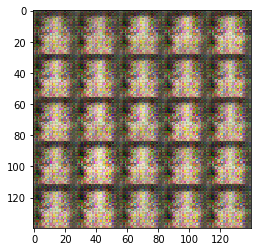

Epoch 1/1... Discriminator Loss: 0.4912... Generator Loss: 3.1039
Epoch 1/1... Discriminator Loss: 1.0061... Generator Loss: 0.9349
Epoch 1/1... Discriminator Loss: 0.4150... Generator Loss: 3.6387
Epoch 1/1... Discriminator Loss: 0.5589... Generator Loss: 2.5759
Epoch 1/1... Discriminator Loss: 0.7354... Generator Loss: 4.6973
Epoch 1/1... Discriminator Loss: 0.4404... Generator Loss: 3.9264
Epoch 1/1... Discriminator Loss: 0.9214... Generator Loss: 1.0853
Epoch 1/1... Discriminator Loss: 0.6041... Generator Loss: 2.1618
Epoch 1/1... Discriminator Loss: 0.7934... Generator Loss: 1.7595
Epoch 1/1... Discriminator Loss: 0.4929... Generator Loss: 2.9259


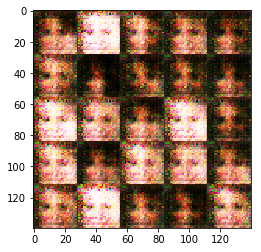

Epoch 1/1... Discriminator Loss: 0.5905... Generator Loss: 5.5273
Epoch 1/1... Discriminator Loss: 1.2245... Generator Loss: 7.6809
Epoch 1/1... Discriminator Loss: 0.5678... Generator Loss: 2.2508
Epoch 1/1... Discriminator Loss: 0.6175... Generator Loss: 5.9142
Epoch 1/1... Discriminator Loss: 0.4156... Generator Loss: 3.6465
Epoch 1/1... Discriminator Loss: 0.4578... Generator Loss: 4.0936
Epoch 1/1... Discriminator Loss: 0.5608... Generator Loss: 3.6974
Epoch 1/1... Discriminator Loss: 0.4943... Generator Loss: 2.4944
Epoch 1/1... Discriminator Loss: 0.6353... Generator Loss: 1.7935
Epoch 1/1... Discriminator Loss: 0.5344... Generator Loss: 2.4489


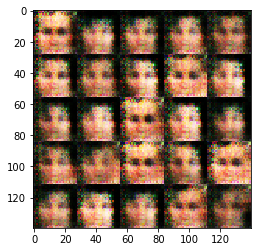

Epoch 1/1... Discriminator Loss: 1.0122... Generator Loss: 1.1528
Epoch 1/1... Discriminator Loss: 0.4698... Generator Loss: 4.5947
Epoch 1/1... Discriminator Loss: 0.4761... Generator Loss: 3.0341
Epoch 1/1... Discriminator Loss: 0.5133... Generator Loss: 2.2569
Epoch 1/1... Discriminator Loss: 0.4860... Generator Loss: 3.9629
Epoch 1/1... Discriminator Loss: 0.7595... Generator Loss: 4.9549
Epoch 1/1... Discriminator Loss: 0.7220... Generator Loss: 1.4175
Epoch 1/1... Discriminator Loss: 1.5618... Generator Loss: 6.1059
Epoch 1/1... Discriminator Loss: 0.6473... Generator Loss: 2.1751
Epoch 1/1... Discriminator Loss: 0.5304... Generator Loss: 2.3887


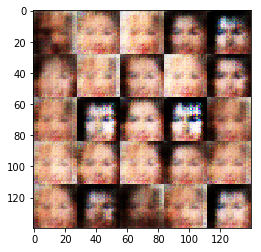

Epoch 1/1... Discriminator Loss: 0.5917... Generator Loss: 2.4986
Epoch 1/1... Discriminator Loss: 0.5926... Generator Loss: 2.6540
Epoch 1/1... Discriminator Loss: 1.9211... Generator Loss: 0.4671
Epoch 1/1... Discriminator Loss: 0.5235... Generator Loss: 2.4768
Epoch 1/1... Discriminator Loss: 0.7026... Generator Loss: 3.2025
Epoch 1/1... Discriminator Loss: 0.6769... Generator Loss: 1.6862
Epoch 1/1... Discriminator Loss: 1.1440... Generator Loss: 0.7956
Epoch 1/1... Discriminator Loss: 0.6096... Generator Loss: 1.6875
Epoch 1/1... Discriminator Loss: 0.6714... Generator Loss: 2.0054
Epoch 1/1... Discriminator Loss: 0.8447... Generator Loss: 3.3371


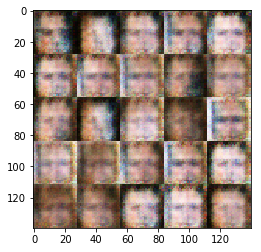

Epoch 1/1... Discriminator Loss: 0.9326... Generator Loss: 1.5063
Epoch 1/1... Discriminator Loss: 0.5686... Generator Loss: 2.1612
Epoch 1/1... Discriminator Loss: 1.3471... Generator Loss: 0.6960
Epoch 1/1... Discriminator Loss: 0.7369... Generator Loss: 1.9344
Epoch 1/1... Discriminator Loss: 0.7545... Generator Loss: 1.6119
Epoch 1/1... Discriminator Loss: 0.6986... Generator Loss: 2.2768
Epoch 1/1... Discriminator Loss: 0.6659... Generator Loss: 1.9427
Epoch 1/1... Discriminator Loss: 0.4636... Generator Loss: 3.0822
Epoch 1/1... Discriminator Loss: 0.9586... Generator Loss: 1.1318
Epoch 1/1... Discriminator Loss: 0.9892... Generator Loss: 2.0055


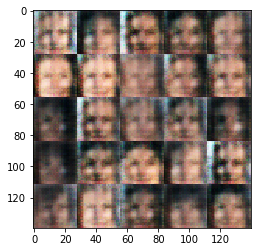

Epoch 1/1... Discriminator Loss: 0.8295... Generator Loss: 1.7043
Epoch 1/1... Discriminator Loss: 0.6637... Generator Loss: 2.0725
Epoch 1/1... Discriminator Loss: 0.9815... Generator Loss: 1.2404
Epoch 1/1... Discriminator Loss: 0.9980... Generator Loss: 1.1276
Epoch 1/1... Discriminator Loss: 0.7561... Generator Loss: 1.7337
Epoch 1/1... Discriminator Loss: 0.5226... Generator Loss: 2.4579
Epoch 1/1... Discriminator Loss: 0.7495... Generator Loss: 2.2835
Epoch 1/1... Discriminator Loss: 1.7425... Generator Loss: 0.4241
Epoch 1/1... Discriminator Loss: 0.8040... Generator Loss: 1.4238
Epoch 1/1... Discriminator Loss: 0.8294... Generator Loss: 2.3449


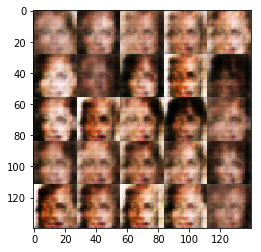

Epoch 1/1... Discriminator Loss: 0.9941... Generator Loss: 1.0144
Epoch 1/1... Discriminator Loss: 0.6629... Generator Loss: 2.1327
Epoch 1/1... Discriminator Loss: 0.7026... Generator Loss: 2.0666
Epoch 1/1... Discriminator Loss: 0.7359... Generator Loss: 1.9858
Epoch 1/1... Discriminator Loss: 0.7410... Generator Loss: 2.1642
Epoch 1/1... Discriminator Loss: 0.6732... Generator Loss: 2.0023
Epoch 1/1... Discriminator Loss: 0.7450... Generator Loss: 1.4685
Epoch 1/1... Discriminator Loss: 0.7346... Generator Loss: 1.9991
Epoch 1/1... Discriminator Loss: 0.7193... Generator Loss: 2.6424
Epoch 1/1... Discriminator Loss: 0.6752... Generator Loss: 2.0560


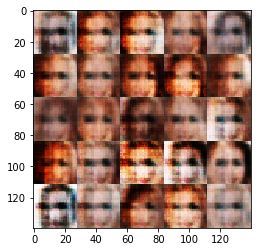

Epoch 1/1... Discriminator Loss: 0.6341... Generator Loss: 2.1802
Epoch 1/1... Discriminator Loss: 0.5915... Generator Loss: 1.8930
Epoch 1/1... Discriminator Loss: 0.6514... Generator Loss: 2.3644
Epoch 1/1... Discriminator Loss: 0.7818... Generator Loss: 1.7058
Epoch 1/1... Discriminator Loss: 0.8000... Generator Loss: 1.6599
Epoch 1/1... Discriminator Loss: 0.6344... Generator Loss: 2.4129
Epoch 1/1... Discriminator Loss: 0.6560... Generator Loss: 2.7965
Epoch 1/1... Discriminator Loss: 0.7334... Generator Loss: 2.9829
Epoch 1/1... Discriminator Loss: 0.7496... Generator Loss: 1.9071
Epoch 1/1... Discriminator Loss: 0.8811... Generator Loss: 1.3272


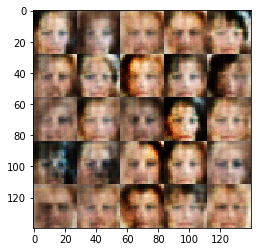

Epoch 1/1... Discriminator Loss: 0.6540... Generator Loss: 2.7027
Epoch 1/1... Discriminator Loss: 0.9296... Generator Loss: 2.5039
Epoch 1/1... Discriminator Loss: 0.7501... Generator Loss: 1.6359
Epoch 1/1... Discriminator Loss: 0.8970... Generator Loss: 1.7077
Epoch 1/1... Discriminator Loss: 0.6121... Generator Loss: 2.4312
Epoch 1/1... Discriminator Loss: 0.8230... Generator Loss: 1.3668
Epoch 1/1... Discriminator Loss: 0.7197... Generator Loss: 1.9193
Epoch 1/1... Discriminator Loss: 0.8717... Generator Loss: 1.0850
Epoch 1/1... Discriminator Loss: 0.7268... Generator Loss: 1.4481
Epoch 1/1... Discriminator Loss: 0.7804... Generator Loss: 1.5805


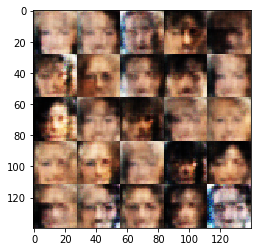

Epoch 1/1... Discriminator Loss: 0.9440... Generator Loss: 1.0633
Epoch 1/1... Discriminator Loss: 0.7768... Generator Loss: 2.4626
Epoch 1/1... Discriminator Loss: 0.6275... Generator Loss: 2.3373
Epoch 1/1... Discriminator Loss: 0.7759... Generator Loss: 1.7664
Epoch 1/1... Discriminator Loss: 0.8770... Generator Loss: 1.6661
Epoch 1/1... Discriminator Loss: 0.7151... Generator Loss: 1.4789
Epoch 1/1... Discriminator Loss: 0.7194... Generator Loss: 2.4401
Epoch 1/1... Discriminator Loss: 0.7326... Generator Loss: 1.5523
Epoch 1/1... Discriminator Loss: 1.0325... Generator Loss: 1.5145
Epoch 1/1... Discriminator Loss: 1.2139... Generator Loss: 3.4538


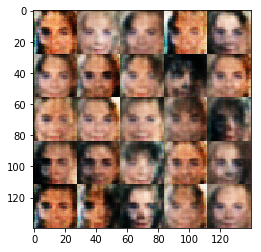

Epoch 1/1... Discriminator Loss: 0.8519... Generator Loss: 1.2915
Epoch 1/1... Discriminator Loss: 0.7868... Generator Loss: 1.8715
Epoch 1/1... Discriminator Loss: 0.8647... Generator Loss: 1.3564
Epoch 1/1... Discriminator Loss: 0.9333... Generator Loss: 1.0297
Epoch 1/1... Discriminator Loss: 0.8643... Generator Loss: 1.6080
Epoch 1/1... Discriminator Loss: 0.7774... Generator Loss: 1.7828
Epoch 1/1... Discriminator Loss: 0.8256... Generator Loss: 1.7035
Epoch 1/1... Discriminator Loss: 0.9742... Generator Loss: 1.3215
Epoch 1/1... Discriminator Loss: 0.9510... Generator Loss: 1.7490
Epoch 1/1... Discriminator Loss: 0.6633... Generator Loss: 1.9361


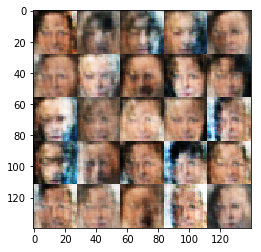

Epoch 1/1... Discriminator Loss: 0.9436... Generator Loss: 0.9273
Epoch 1/1... Discriminator Loss: 0.8614... Generator Loss: 1.5848
Epoch 1/1... Discriminator Loss: 0.7722... Generator Loss: 2.6584
Epoch 1/1... Discriminator Loss: 0.8726... Generator Loss: 2.4091
Epoch 1/1... Discriminator Loss: 0.9677... Generator Loss: 0.9651
Epoch 1/1... Discriminator Loss: 0.7518... Generator Loss: 1.7449
Epoch 1/1... Discriminator Loss: 0.7005... Generator Loss: 1.9402
Epoch 1/1... Discriminator Loss: 1.0775... Generator Loss: 0.9375
Epoch 1/1... Discriminator Loss: 0.8176... Generator Loss: 1.8242
Epoch 1/1... Discriminator Loss: 0.8636... Generator Loss: 1.4363


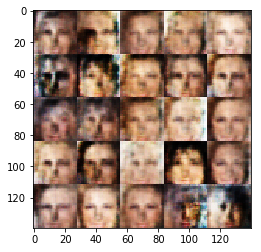

Epoch 1/1... Discriminator Loss: 0.7660... Generator Loss: 1.7657
Epoch 1/1... Discriminator Loss: 0.8051... Generator Loss: 1.3592
Epoch 1/1... Discriminator Loss: 1.0411... Generator Loss: 1.2384
Epoch 1/1... Discriminator Loss: 1.4771... Generator Loss: 0.5162
Epoch 1/1... Discriminator Loss: 0.8228... Generator Loss: 1.6365
Epoch 1/1... Discriminator Loss: 0.9770... Generator Loss: 1.7218
Epoch 1/1... Discriminator Loss: 1.3174... Generator Loss: 0.6529
Epoch 1/1... Discriminator Loss: 1.2484... Generator Loss: 1.0761
Epoch 1/1... Discriminator Loss: 0.9541... Generator Loss: 1.6997
Epoch 1/1... Discriminator Loss: 0.9000... Generator Loss: 1.5098


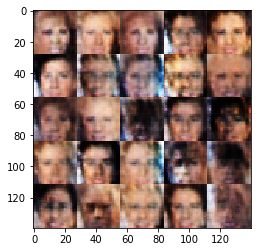

Epoch 1/1... Discriminator Loss: 0.7178... Generator Loss: 1.6710
Epoch 1/1... Discriminator Loss: 0.8618... Generator Loss: 1.3713
Epoch 1/1... Discriminator Loss: 0.7721... Generator Loss: 1.9593
Epoch 1/1... Discriminator Loss: 0.9932... Generator Loss: 1.4639
Epoch 1/1... Discriminator Loss: 0.8205... Generator Loss: 1.7140
Epoch 1/1... Discriminator Loss: 0.9468... Generator Loss: 1.0653
Epoch 1/1... Discriminator Loss: 1.0581... Generator Loss: 1.1838
Epoch 1/1... Discriminator Loss: 0.5392... Generator Loss: 2.7758
Epoch 1/1... Discriminator Loss: 1.0273... Generator Loss: 1.2166
Epoch 1/1... Discriminator Loss: 0.7323... Generator Loss: 1.6194


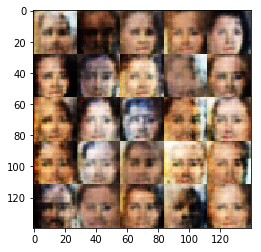

Epoch 1/1... Discriminator Loss: 0.8877... Generator Loss: 2.3204
Epoch 1/1... Discriminator Loss: 1.0400... Generator Loss: 1.0518
Epoch 1/1... Discriminator Loss: 1.0330... Generator Loss: 1.0556
Epoch 1/1... Discriminator Loss: 0.6883... Generator Loss: 1.9119
Epoch 1/1... Discriminator Loss: 0.7863... Generator Loss: 2.1344
Epoch 1/1... Discriminator Loss: 0.8008... Generator Loss: 2.0086
Epoch 1/1... Discriminator Loss: 0.8099... Generator Loss: 2.3645
Epoch 1/1... Discriminator Loss: 0.9246... Generator Loss: 1.2382
Epoch 1/1... Discriminator Loss: 0.7186... Generator Loss: 2.3366
Epoch 1/1... Discriminator Loss: 1.1377... Generator Loss: 1.0493


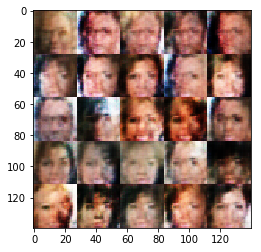

Epoch 1/1... Discriminator Loss: 0.9727... Generator Loss: 1.3352
Epoch 1/1... Discriminator Loss: 0.8065... Generator Loss: 2.2979
Epoch 1/1... Discriminator Loss: 0.9504... Generator Loss: 1.9504
Epoch 1/1... Discriminator Loss: 1.0360... Generator Loss: 1.6964
Epoch 1/1... Discriminator Loss: 0.8740... Generator Loss: 1.2472
Epoch 1/1... Discriminator Loss: 0.9504... Generator Loss: 1.1755
Epoch 1/1... Discriminator Loss: 0.9180... Generator Loss: 1.3405
Epoch 1/1... Discriminator Loss: 0.9867... Generator Loss: 1.5253
Epoch 1/1... Discriminator Loss: 0.8977... Generator Loss: 2.4009
Epoch 1/1... Discriminator Loss: 0.8618... Generator Loss: 1.6701


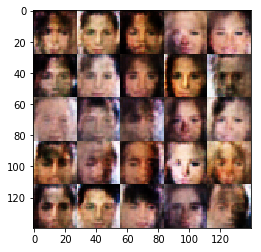

Epoch 1/1... Discriminator Loss: 0.9902... Generator Loss: 1.1679
Epoch 1/1... Discriminator Loss: 0.9302... Generator Loss: 1.2356
Epoch 1/1... Discriminator Loss: 0.8069... Generator Loss: 1.9517
Epoch 1/1... Discriminator Loss: 0.7547... Generator Loss: 1.4642
Epoch 1/1... Discriminator Loss: 0.8055... Generator Loss: 2.0083
Epoch 1/1... Discriminator Loss: 0.8554... Generator Loss: 1.3295
Epoch 1/1... Discriminator Loss: 0.8256... Generator Loss: 1.6797
Epoch 1/1... Discriminator Loss: 1.0054... Generator Loss: 1.0380
Epoch 1/1... Discriminator Loss: 1.0118... Generator Loss: 1.4282
Epoch 1/1... Discriminator Loss: 0.7491... Generator Loss: 2.0418


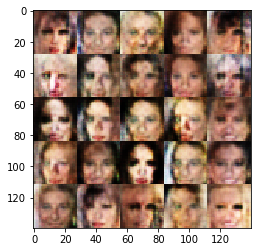

Epoch 1/1... Discriminator Loss: 0.7052... Generator Loss: 2.3431
Epoch 1/1... Discriminator Loss: 0.7291... Generator Loss: 2.8699
Epoch 1/1... Discriminator Loss: 0.8113... Generator Loss: 1.6166
Epoch 1/1... Discriminator Loss: 0.7774... Generator Loss: 1.8863
Epoch 1/1... Discriminator Loss: 0.8333... Generator Loss: 2.0344
Epoch 1/1... Discriminator Loss: 0.8565... Generator Loss: 1.2645
Epoch 1/1... Discriminator Loss: 0.6905... Generator Loss: 2.0093
Epoch 1/1... Discriminator Loss: 0.7660... Generator Loss: 1.6731
Epoch 1/1... Discriminator Loss: 0.9573... Generator Loss: 1.0203
Epoch 1/1... Discriminator Loss: 0.8357... Generator Loss: 1.5097


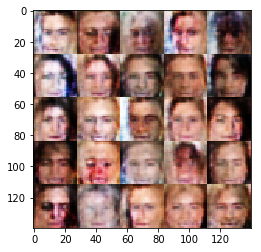

Epoch 1/1... Discriminator Loss: 0.9604... Generator Loss: 1.6427
Epoch 1/1... Discriminator Loss: 0.7645... Generator Loss: 1.8750
Epoch 1/1... Discriminator Loss: 0.8393... Generator Loss: 1.6420
Epoch 1/1... Discriminator Loss: 0.9224... Generator Loss: 1.6478
Epoch 1/1... Discriminator Loss: 0.7558... Generator Loss: 1.8263
Epoch 1/1... Discriminator Loss: 0.8984... Generator Loss: 1.8336
Epoch 1/1... Discriminator Loss: 0.7298... Generator Loss: 1.7153
Epoch 1/1... Discriminator Loss: 0.6775... Generator Loss: 2.1510
Epoch 1/1... Discriminator Loss: 0.6995... Generator Loss: 1.6308
Epoch 1/1... Discriminator Loss: 0.8352... Generator Loss: 1.4429


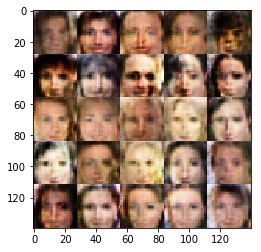

Epoch 1/1... Discriminator Loss: 1.0088... Generator Loss: 2.0470
Epoch 1/1... Discriminator Loss: 0.7727... Generator Loss: 1.5686
Epoch 1/1... Discriminator Loss: 0.9132... Generator Loss: 2.1473
Epoch 1/1... Discriminator Loss: 0.8739... Generator Loss: 3.0988
Epoch 1/1... Discriminator Loss: 1.1095... Generator Loss: 1.7168
Epoch 1/1... Discriminator Loss: 0.8217... Generator Loss: 1.8459
Epoch 1/1... Discriminator Loss: 0.9196... Generator Loss: 1.2820
Epoch 1/1... Discriminator Loss: 0.7629... Generator Loss: 2.2131
Epoch 1/1... Discriminator Loss: 0.9303... Generator Loss: 1.4489
Epoch 1/1... Discriminator Loss: 0.9678... Generator Loss: 1.2290


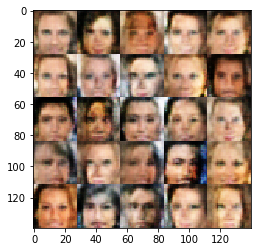

Epoch 1/1... Discriminator Loss: 0.7169... Generator Loss: 1.6182
Epoch 1/1... Discriminator Loss: 0.8348... Generator Loss: 1.8126
Epoch 1/1... Discriminator Loss: 0.8542... Generator Loss: 1.2315
Epoch 1/1... Discriminator Loss: 0.7354... Generator Loss: 2.0182
Epoch 1/1... Discriminator Loss: 0.9450... Generator Loss: 1.2010
Epoch 1/1... Discriminator Loss: 0.8042... Generator Loss: 1.6922
Epoch 1/1... Discriminator Loss: 0.9107... Generator Loss: 1.1034
Epoch 1/1... Discriminator Loss: 0.7517... Generator Loss: 1.5729
Epoch 1/1... Discriminator Loss: 0.8851... Generator Loss: 1.0396
Epoch 1/1... Discriminator Loss: 0.8306... Generator Loss: 1.9789


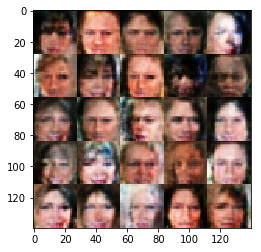

Epoch 1/1... Discriminator Loss: 0.8195... Generator Loss: 1.6268
Epoch 1/1... Discriminator Loss: 1.0417... Generator Loss: 0.7489
Epoch 1/1... Discriminator Loss: 0.7853... Generator Loss: 1.3954
Epoch 1/1... Discriminator Loss: 0.8832... Generator Loss: 1.4301
Epoch 1/1... Discriminator Loss: 0.8901... Generator Loss: 1.1631
Epoch 1/1... Discriminator Loss: 0.8624... Generator Loss: 1.2562
Epoch 1/1... Discriminator Loss: 0.6358... Generator Loss: 2.3035
Epoch 1/1... Discriminator Loss: 0.9446... Generator Loss: 1.4924
Epoch 1/1... Discriminator Loss: 0.9585... Generator Loss: 1.1176
Epoch 1/1... Discriminator Loss: 0.8021... Generator Loss: 1.8441


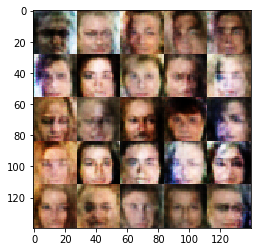

Epoch 1/1... Discriminator Loss: 0.7985... Generator Loss: 2.0251
Epoch 1/1... Discriminator Loss: 1.1802... Generator Loss: 3.0817
Epoch 1/1... Discriminator Loss: 0.9687... Generator Loss: 1.2188
Epoch 1/1... Discriminator Loss: 1.0392... Generator Loss: 1.4592
Epoch 1/1... Discriminator Loss: 0.8641... Generator Loss: 1.8691
Epoch 1/1... Discriminator Loss: 0.8243... Generator Loss: 1.1272
Epoch 1/1... Discriminator Loss: 0.6804... Generator Loss: 1.9503
Epoch 1/1... Discriminator Loss: 0.9846... Generator Loss: 2.2988
Epoch 1/1... Discriminator Loss: 1.0592... Generator Loss: 2.5857
Epoch 1/1... Discriminator Loss: 0.7165... Generator Loss: 1.6747


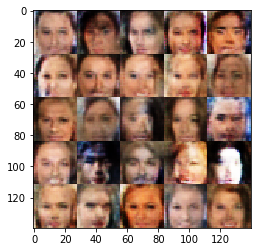

Epoch 1/1... Discriminator Loss: 1.0985... Generator Loss: 0.8037
Epoch 1/1... Discriminator Loss: 0.9226... Generator Loss: 1.1757
Epoch 1/1... Discriminator Loss: 0.8587... Generator Loss: 1.6632
Epoch 1/1... Discriminator Loss: 0.9513... Generator Loss: 1.1668
Epoch 1/1... Discriminator Loss: 0.8012... Generator Loss: 1.4202
Epoch 1/1... Discriminator Loss: 1.0803... Generator Loss: 1.2197
Epoch 1/1... Discriminator Loss: 0.9896... Generator Loss: 1.2937
Epoch 1/1... Discriminator Loss: 0.8780... Generator Loss: 1.2887
Epoch 1/1... Discriminator Loss: 0.9904... Generator Loss: 0.8800
Epoch 1/1... Discriminator Loss: 1.0748... Generator Loss: 1.1015


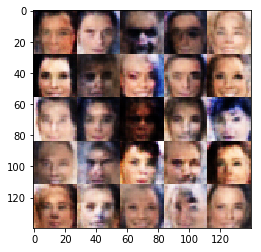

Epoch 1/1... Discriminator Loss: 0.7231... Generator Loss: 1.6938
Epoch 1/1... Discriminator Loss: 0.8877... Generator Loss: 1.9426
Epoch 1/1... Discriminator Loss: 0.7461... Generator Loss: 1.9659
Epoch 1/1... Discriminator Loss: 1.0931... Generator Loss: 1.1885
Epoch 1/1... Discriminator Loss: 0.8709... Generator Loss: 1.1464
Epoch 1/1... Discriminator Loss: 0.9546... Generator Loss: 1.8226
Epoch 1/1... Discriminator Loss: 0.7977... Generator Loss: 1.8575
Epoch 1/1... Discriminator Loss: 0.8027... Generator Loss: 1.7710
Epoch 1/1... Discriminator Loss: 1.2385... Generator Loss: 1.1756
Epoch 1/1... Discriminator Loss: 0.7803... Generator Loss: 1.4071


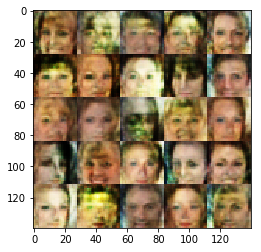

Epoch 1/1... Discriminator Loss: 1.4764... Generator Loss: 0.5962
Epoch 1/1... Discriminator Loss: 0.8881... Generator Loss: 1.3639
Epoch 1/1... Discriminator Loss: 0.9633... Generator Loss: 3.1740
Epoch 1/1... Discriminator Loss: 1.0197... Generator Loss: 1.7166
Epoch 1/1... Discriminator Loss: 0.9833... Generator Loss: 1.7373
Epoch 1/1... Discriminator Loss: 0.8203... Generator Loss: 1.5005
Epoch 1/1... Discriminator Loss: 0.7939... Generator Loss: 1.6652
Epoch 1/1... Discriminator Loss: 1.3241... Generator Loss: 0.7765
Epoch 1/1... Discriminator Loss: 0.8767... Generator Loss: 1.8447
Epoch 1/1... Discriminator Loss: 0.8588... Generator Loss: 2.6546


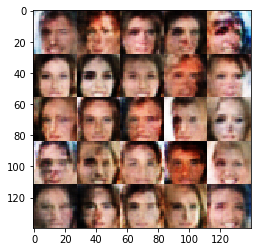

Epoch 1/1... Discriminator Loss: 0.8432... Generator Loss: 1.6550
Epoch 1/1... Discriminator Loss: 0.8045... Generator Loss: 1.8444
Epoch 1/1... Discriminator Loss: 1.1214... Generator Loss: 1.0629
Epoch 1/1... Discriminator Loss: 0.8071... Generator Loss: 2.9592
Epoch 1/1... Discriminator Loss: 0.7082... Generator Loss: 2.0317
Epoch 1/1... Discriminator Loss: 1.1139... Generator Loss: 3.2277
Epoch 1/1... Discriminator Loss: 1.0692... Generator Loss: 0.8723
Epoch 1/1... Discriminator Loss: 0.9003... Generator Loss: 1.4022
Epoch 1/1... Discriminator Loss: 1.0197... Generator Loss: 1.3748
Epoch 1/1... Discriminator Loss: 1.1029... Generator Loss: 1.2552


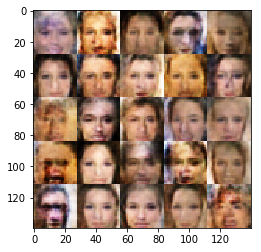

Epoch 1/1... Discriminator Loss: 0.7722... Generator Loss: 1.8231
Epoch 1/1... Discriminator Loss: 1.0074... Generator Loss: 1.4342
Epoch 1/1... Discriminator Loss: 0.9924... Generator Loss: 1.6905
Epoch 1/1... Discriminator Loss: 1.0864... Generator Loss: 1.0809
Epoch 1/1... Discriminator Loss: 1.0296... Generator Loss: 1.4907
Epoch 1/1... Discriminator Loss: 0.9909... Generator Loss: 1.6130
Epoch 1/1... Discriminator Loss: 0.8179... Generator Loss: 2.0829
Epoch 1/1... Discriminator Loss: 1.0963... Generator Loss: 0.8784
Epoch 1/1... Discriminator Loss: 1.1223... Generator Loss: 1.0202
Epoch 1/1... Discriminator Loss: 0.9458... Generator Loss: 1.5465


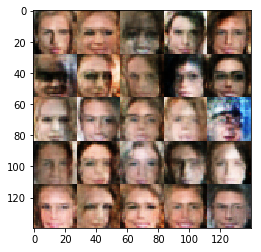

Epoch 1/1... Discriminator Loss: 1.1856... Generator Loss: 1.0043
Epoch 1/1... Discriminator Loss: 0.9487... Generator Loss: 1.1622
Epoch 1/1... Discriminator Loss: 0.7421... Generator Loss: 1.9779
Epoch 1/1... Discriminator Loss: 1.0076... Generator Loss: 3.2379
Epoch 1/1... Discriminator Loss: 0.8844... Generator Loss: 1.5284
Epoch 1/1... Discriminator Loss: 0.8278... Generator Loss: 1.5267
Epoch 1/1... Discriminator Loss: 0.7476... Generator Loss: 1.5881
Epoch 1/1... Discriminator Loss: 0.7434... Generator Loss: 1.9212
Epoch 1/1... Discriminator Loss: 0.7350... Generator Loss: 2.6029
Epoch 1/1... Discriminator Loss: 0.8731... Generator Loss: 1.6263


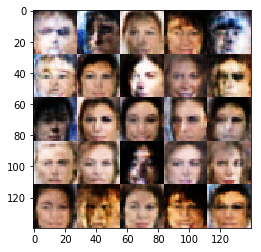

Epoch 1/1... Discriminator Loss: 0.7923... Generator Loss: 1.5384
Epoch 1/1... Discriminator Loss: 0.8906... Generator Loss: 1.4041
Epoch 1/1... Discriminator Loss: 0.9524... Generator Loss: 1.1045
Epoch 1/1... Discriminator Loss: 0.7126... Generator Loss: 1.9101
Epoch 1/1... Discriminator Loss: 0.6544... Generator Loss: 1.9220
Epoch 1/1... Discriminator Loss: 0.7831... Generator Loss: 1.6360
Epoch 1/1... Discriminator Loss: 0.8997... Generator Loss: 1.3829
Epoch 1/1... Discriminator Loss: 0.7423... Generator Loss: 1.6279
Epoch 1/1... Discriminator Loss: 1.1676... Generator Loss: 0.7792
Epoch 1/1... Discriminator Loss: 1.0477... Generator Loss: 1.1693


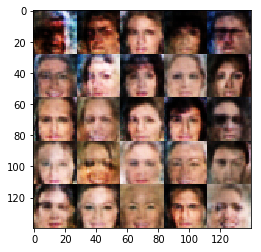

Epoch 1/1... Discriminator Loss: 1.0723... Generator Loss: 0.8899
Epoch 1/1... Discriminator Loss: 0.9557... Generator Loss: 1.1162
Epoch 1/1... Discriminator Loss: 0.6885... Generator Loss: 1.8808
Epoch 1/1... Discriminator Loss: 0.7525... Generator Loss: 1.8463
Epoch 1/1... Discriminator Loss: 1.0446... Generator Loss: 0.9023
Epoch 1/1... Discriminator Loss: 0.8441... Generator Loss: 1.7030
Epoch 1/1... Discriminator Loss: 0.7047... Generator Loss: 1.9174
Epoch 1/1... Discriminator Loss: 0.8077... Generator Loss: 1.7728
Epoch 1/1... Discriminator Loss: 1.0705... Generator Loss: 0.9353
Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 0.5992


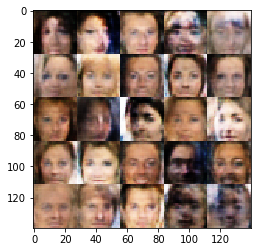

Epoch 1/1... Discriminator Loss: 0.8155... Generator Loss: 1.5422
Epoch 1/1... Discriminator Loss: 0.9928... Generator Loss: 1.6031
Epoch 1/1... Discriminator Loss: 0.8301... Generator Loss: 1.4572
Epoch 1/1... Discriminator Loss: 0.8570... Generator Loss: 1.9773
Epoch 1/1... Discriminator Loss: 0.8078... Generator Loss: 1.7735
Epoch 1/1... Discriminator Loss: 1.0623... Generator Loss: 0.9753
Epoch 1/1... Discriminator Loss: 0.7809... Generator Loss: 1.6443
Epoch 1/1... Discriminator Loss: 0.9745... Generator Loss: 2.3685
Epoch 1/1... Discriminator Loss: 1.0481... Generator Loss: 1.1043
Epoch 1/1... Discriminator Loss: 0.9206... Generator Loss: 1.5062


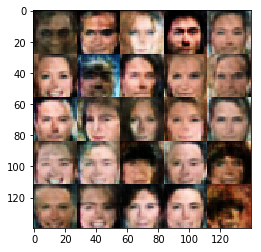

Epoch 1/1... Discriminator Loss: 0.9645... Generator Loss: 1.1931
Epoch 1/1... Discriminator Loss: 0.8686... Generator Loss: 1.0639
Epoch 1/1... Discriminator Loss: 0.8528... Generator Loss: 1.3698
Epoch 1/1... Discriminator Loss: 0.7940... Generator Loss: 1.4691
Epoch 1/1... Discriminator Loss: 1.1215... Generator Loss: 0.8415
Epoch 1/1... Discriminator Loss: 0.8519... Generator Loss: 1.5484
Epoch 1/1... Discriminator Loss: 1.2581... Generator Loss: 0.5599
Epoch 1/1... Discriminator Loss: 0.9274... Generator Loss: 1.2442
Epoch 1/1... Discriminator Loss: 0.7725... Generator Loss: 1.6483
Epoch 1/1... Discriminator Loss: 0.7577... Generator Loss: 1.5114


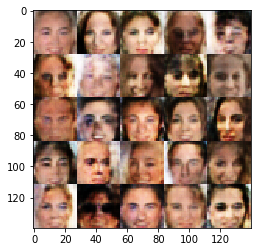

Epoch 1/1... Discriminator Loss: 0.9421... Generator Loss: 1.4102
Epoch 1/1... Discriminator Loss: 0.9473... Generator Loss: 1.9878
Epoch 1/1... Discriminator Loss: 0.8339... Generator Loss: 1.5492
Epoch 1/1... Discriminator Loss: 0.8636... Generator Loss: 1.4177
Epoch 1/1... Discriminator Loss: 0.8816... Generator Loss: 1.5527
Epoch 1/1... Discriminator Loss: 0.8906... Generator Loss: 1.3784
Epoch 1/1... Discriminator Loss: 0.7332... Generator Loss: 1.8199
Epoch 1/1... Discriminator Loss: 1.0521... Generator Loss: 0.9426
Epoch 1/1... Discriminator Loss: 0.7698... Generator Loss: 1.4500
Epoch 1/1... Discriminator Loss: 0.8366... Generator Loss: 1.0490


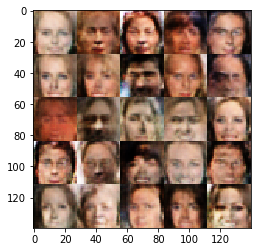

Epoch 1/1... Discriminator Loss: 0.6314... Generator Loss: 2.0131
Epoch 1/1... Discriminator Loss: 0.9097... Generator Loss: 1.7943
Epoch 1/1... Discriminator Loss: 0.7862... Generator Loss: 1.2917
Epoch 1/1... Discriminator Loss: 0.7505... Generator Loss: 1.6988
Epoch 1/1... Discriminator Loss: 0.9294... Generator Loss: 1.2820
Epoch 1/1... Discriminator Loss: 1.0096... Generator Loss: 1.1583
Epoch 1/1... Discriminator Loss: 0.8127... Generator Loss: 1.5707
Epoch 1/1... Discriminator Loss: 0.8665... Generator Loss: 1.5059
Epoch 1/1... Discriminator Loss: 0.8276... Generator Loss: 1.6433
Epoch 1/1... Discriminator Loss: 0.9788... Generator Loss: 2.2302


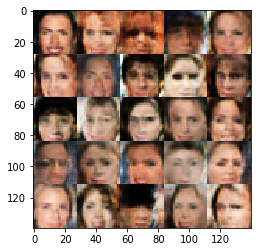

Epoch 1/1... Discriminator Loss: 0.8282... Generator Loss: 1.3435
Epoch 1/1... Discriminator Loss: 1.0299... Generator Loss: 1.1407
Epoch 1/1... Discriminator Loss: 0.7735... Generator Loss: 1.6215
Epoch 1/1... Discriminator Loss: 0.7807... Generator Loss: 1.4605
Epoch 1/1... Discriminator Loss: 0.8396... Generator Loss: 1.4618
Epoch 1/1... Discriminator Loss: 0.7706... Generator Loss: 1.4812
Epoch 1/1... Discriminator Loss: 0.8884... Generator Loss: 1.7049
Epoch 1/1... Discriminator Loss: 0.8334... Generator Loss: 1.3413
Epoch 1/1... Discriminator Loss: 0.8063... Generator Loss: 1.4158
Epoch 1/1... Discriminator Loss: 0.8501... Generator Loss: 1.6419


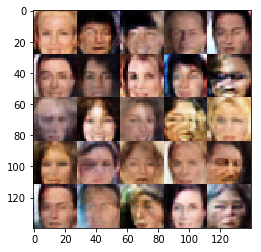

Epoch 1/1... Discriminator Loss: 1.0498... Generator Loss: 0.9023
Epoch 1/1... Discriminator Loss: 0.8813... Generator Loss: 1.9491
Epoch 1/1... Discriminator Loss: 0.7122... Generator Loss: 1.8221
Epoch 1/1... Discriminator Loss: 0.7324... Generator Loss: 1.5288
Epoch 1/1... Discriminator Loss: 1.1014... Generator Loss: 0.7784
Epoch 1/1... Discriminator Loss: 0.9026... Generator Loss: 1.6520
Epoch 1/1... Discriminator Loss: 0.8324... Generator Loss: 1.4178
Epoch 1/1... Discriminator Loss: 1.1345... Generator Loss: 1.3105
Epoch 1/1... Discriminator Loss: 0.7783... Generator Loss: 1.5646
Epoch 1/1... Discriminator Loss: 0.8139... Generator Loss: 1.3815


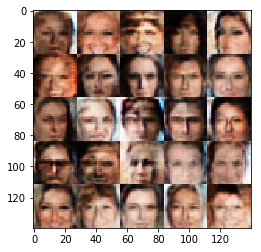

Epoch 1/1... Discriminator Loss: 1.0304... Generator Loss: 1.0661
Epoch 1/1... Discriminator Loss: 0.7051... Generator Loss: 1.7358
Epoch 1/1... Discriminator Loss: 0.6697... Generator Loss: 2.1075
Epoch 1/1... Discriminator Loss: 1.1301... Generator Loss: 1.0866
Epoch 1/1... Discriminator Loss: 0.6999... Generator Loss: 1.3518
Epoch 1/1... Discriminator Loss: 0.7222... Generator Loss: 1.6623
Epoch 1/1... Discriminator Loss: 0.7824... Generator Loss: 1.5141
Epoch 1/1... Discriminator Loss: 1.0493... Generator Loss: 0.8350
Epoch 1/1... Discriminator Loss: 0.8156... Generator Loss: 1.7561
Epoch 1/1... Discriminator Loss: 0.7000... Generator Loss: 1.9145


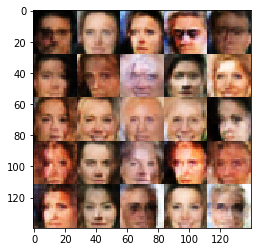

Epoch 1/1... Discriminator Loss: 0.9913... Generator Loss: 1.2148
Epoch 1/1... Discriminator Loss: 0.7107... Generator Loss: 1.6030
Epoch 1/1... Discriminator Loss: 0.8962... Generator Loss: 1.0580
Epoch 1/1... Discriminator Loss: 0.7841... Generator Loss: 1.6763
Epoch 1/1... Discriminator Loss: 0.8737... Generator Loss: 1.2954
Epoch 1/1... Discriminator Loss: 0.9083... Generator Loss: 1.8622
Epoch 1/1... Discriminator Loss: 0.7705... Generator Loss: 1.7894
Epoch 1/1... Discriminator Loss: 0.7674... Generator Loss: 1.7975
Epoch 1/1... Discriminator Loss: 0.8878... Generator Loss: 1.2716
Epoch 1/1... Discriminator Loss: 0.6222... Generator Loss: 2.2503


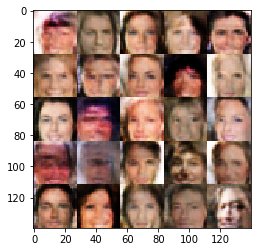

Epoch 1/1... Discriminator Loss: 0.7423... Generator Loss: 1.2090
Epoch 1/1... Discriminator Loss: 1.0514... Generator Loss: 0.8608
Epoch 1/1... Discriminator Loss: 0.9745... Generator Loss: 1.0222
Epoch 1/1... Discriminator Loss: 0.8262... Generator Loss: 2.0067
Epoch 1/1... Discriminator Loss: 1.3356... Generator Loss: 0.8482
Epoch 1/1... Discriminator Loss: 1.0638... Generator Loss: 1.0757
Epoch 1/1... Discriminator Loss: 1.0160... Generator Loss: 1.0771
Epoch 1/1... Discriminator Loss: 0.7292... Generator Loss: 1.9441
Epoch 1/1... Discriminator Loss: 1.0071... Generator Loss: 0.8830
Epoch 1/1... Discriminator Loss: 0.8630... Generator Loss: 1.3955


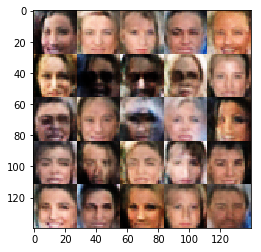

Epoch 1/1... Discriminator Loss: 0.7997... Generator Loss: 1.5618
Epoch 1/1... Discriminator Loss: 0.7211... Generator Loss: 1.4607
Epoch 1/1... Discriminator Loss: 0.9693... Generator Loss: 1.0470
Epoch 1/1... Discriminator Loss: 1.0128... Generator Loss: 1.7196
Epoch 1/1... Discriminator Loss: 0.7116... Generator Loss: 1.6356
Epoch 1/1... Discriminator Loss: 0.9682... Generator Loss: 1.5141
Epoch 1/1... Discriminator Loss: 0.8007... Generator Loss: 1.2223
Epoch 1/1... Discriminator Loss: 1.0111... Generator Loss: 1.1579
Epoch 1/1... Discriminator Loss: 0.8983... Generator Loss: 2.1331
Epoch 1/1... Discriminator Loss: 1.0222... Generator Loss: 0.8892


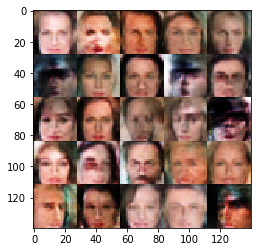

Epoch 1/1... Discriminator Loss: 0.8094... Generator Loss: 2.3103
Epoch 1/1... Discriminator Loss: 0.9396... Generator Loss: 1.5703
Epoch 1/1... Discriminator Loss: 0.7174... Generator Loss: 1.8832
Epoch 1/1... Discriminator Loss: 0.8274... Generator Loss: 1.2411
Epoch 1/1... Discriminator Loss: 0.8763... Generator Loss: 1.5070
Epoch 1/1... Discriminator Loss: 0.7239... Generator Loss: 1.8687
Epoch 1/1... Discriminator Loss: 0.7821... Generator Loss: 1.8164
Epoch 1/1... Discriminator Loss: 0.6850... Generator Loss: 1.4104
Epoch 1/1... Discriminator Loss: 0.8137... Generator Loss: 1.4831
Epoch 1/1... Discriminator Loss: 0.7950... Generator Loss: 1.6121


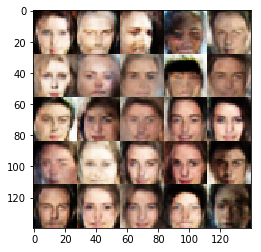

Epoch 1/1... Discriminator Loss: 0.7848... Generator Loss: 1.8070
Epoch 1/1... Discriminator Loss: 0.9643... Generator Loss: 1.4043
Epoch 1/1... Discriminator Loss: 0.7746... Generator Loss: 1.9790
Epoch 1/1... Discriminator Loss: 0.7393... Generator Loss: 1.5593
Epoch 1/1... Discriminator Loss: 0.9756... Generator Loss: 1.4907
Epoch 1/1... Discriminator Loss: 0.9736... Generator Loss: 0.9348
Epoch 1/1... Discriminator Loss: 1.1959... Generator Loss: 0.7517
Epoch 1/1... Discriminator Loss: 0.9262... Generator Loss: 1.4638
Epoch 1/1... Discriminator Loss: 1.2917... Generator Loss: 0.9052
Epoch 1/1... Discriminator Loss: 0.8112... Generator Loss: 1.5554


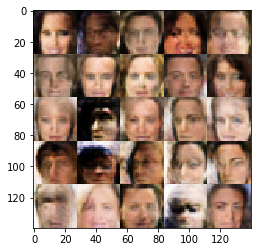

Epoch 1/1... Discriminator Loss: 0.7892... Generator Loss: 1.6696
Epoch 1/1... Discriminator Loss: 0.8018... Generator Loss: 1.9296
Epoch 1/1... Discriminator Loss: 1.0605... Generator Loss: 1.8946
Epoch 1/1... Discriminator Loss: 0.9313... Generator Loss: 1.6885
Epoch 1/1... Discriminator Loss: 0.9342... Generator Loss: 1.1262
Epoch 1/1... Discriminator Loss: 0.8732... Generator Loss: 1.6535
Epoch 1/1... Discriminator Loss: 0.6904... Generator Loss: 1.6419
Epoch 1/1... Discriminator Loss: 0.6820... Generator Loss: 1.5537
Epoch 1/1... Discriminator Loss: 0.9292... Generator Loss: 1.0888
Epoch 1/1... Discriminator Loss: 0.8336... Generator Loss: 1.0575


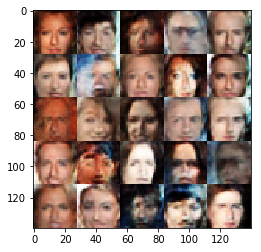

Epoch 1/1... Discriminator Loss: 0.7360... Generator Loss: 2.4314
Epoch 1/1... Discriminator Loss: 0.9915... Generator Loss: 1.1465
Epoch 1/1... Discriminator Loss: 1.0291... Generator Loss: 0.9781
Epoch 1/1... Discriminator Loss: 0.7519... Generator Loss: 1.6715
Epoch 1/1... Discriminator Loss: 0.8665... Generator Loss: 1.3024
Epoch 1/1... Discriminator Loss: 0.8759... Generator Loss: 1.4540
Epoch 1/1... Discriminator Loss: 0.7040... Generator Loss: 1.9440
Epoch 1/1... Discriminator Loss: 0.5792... Generator Loss: 3.2320
Epoch 1/1... Discriminator Loss: 0.6174... Generator Loss: 2.0403
Epoch 1/1... Discriminator Loss: 0.6339... Generator Loss: 2.3075


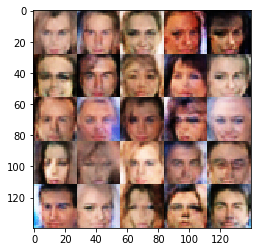

Epoch 1/1... Discriminator Loss: 0.6898... Generator Loss: 1.7998
Epoch 1/1... Discriminator Loss: 0.6551... Generator Loss: 2.0794
Epoch 1/1... Discriminator Loss: 0.5741... Generator Loss: 1.9902
Epoch 1/1... Discriminator Loss: 0.9652... Generator Loss: 1.3689
Epoch 1/1... Discriminator Loss: 0.8280... Generator Loss: 1.4944
Epoch 1/1... Discriminator Loss: 0.7947... Generator Loss: 1.2619
Epoch 1/1... Discriminator Loss: 0.8839... Generator Loss: 2.2530
Epoch 1/1... Discriminator Loss: 0.9508... Generator Loss: 2.3259
Epoch 1/1... Discriminator Loss: 1.0360... Generator Loss: 0.8372
Epoch 1/1... Discriminator Loss: 0.7804... Generator Loss: 1.5243


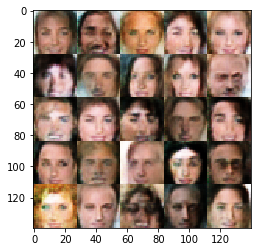

Epoch 1/1... Discriminator Loss: 0.7758... Generator Loss: 1.5746
Epoch 1/1... Discriminator Loss: 0.7489... Generator Loss: 1.4468
Epoch 1/1... Discriminator Loss: 0.8598... Generator Loss: 1.1680
Epoch 1/1... Discriminator Loss: 0.8405... Generator Loss: 1.4408
Epoch 1/1... Discriminator Loss: 0.6647... Generator Loss: 1.8740
Epoch 1/1... Discriminator Loss: 0.7947... Generator Loss: 1.8401
Epoch 1/1... Discriminator Loss: 0.9466... Generator Loss: 1.2270
Epoch 1/1... Discriminator Loss: 0.8028... Generator Loss: 2.1535
Epoch 1/1... Discriminator Loss: 1.0086... Generator Loss: 0.9626
Epoch 1/1... Discriminator Loss: 0.7631... Generator Loss: 1.3890


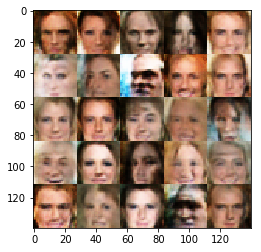

Epoch 1/1... Discriminator Loss: 0.8890... Generator Loss: 2.1292
Epoch 1/1... Discriminator Loss: 0.7432... Generator Loss: 1.7818
Epoch 1/1... Discriminator Loss: 0.9287... Generator Loss: 1.1359
Epoch 1/1... Discriminator Loss: 0.7927... Generator Loss: 2.0797
Epoch 1/1... Discriminator Loss: 0.9139... Generator Loss: 1.1059
Epoch 1/1... Discriminator Loss: 0.8104... Generator Loss: 1.5242
Epoch 1/1... Discriminator Loss: 0.6759... Generator Loss: 1.4799
Epoch 1/1... Discriminator Loss: 0.8102... Generator Loss: 2.0456
Epoch 1/1... Discriminator Loss: 0.8402... Generator Loss: 1.9265
Epoch 1/1... Discriminator Loss: 0.8004... Generator Loss: 1.7754


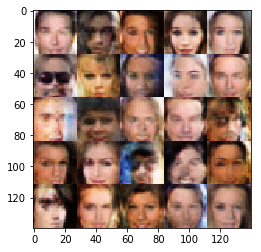

Epoch 1/1... Discriminator Loss: 0.8916... Generator Loss: 1.1757
Epoch 1/1... Discriminator Loss: 0.8608... Generator Loss: 0.8894
Epoch 1/1... Discriminator Loss: 0.7931... Generator Loss: 1.7308
Epoch 1/1... Discriminator Loss: 0.9237... Generator Loss: 1.1254
Epoch 1/1... Discriminator Loss: 0.7955... Generator Loss: 1.4038
Epoch 1/1... Discriminator Loss: 0.9230... Generator Loss: 1.3413
Epoch 1/1... Discriminator Loss: 0.7860... Generator Loss: 1.7649
Epoch 1/1... Discriminator Loss: 0.6882... Generator Loss: 1.4914
Epoch 1/1... Discriminator Loss: 0.7786... Generator Loss: 1.6301
Epoch 1/1... Discriminator Loss: 1.0200... Generator Loss: 2.1499


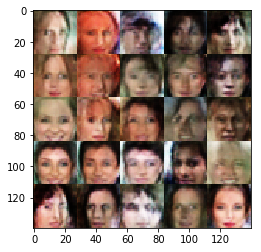

Epoch 1/1... Discriminator Loss: 0.8819... Generator Loss: 1.2982
Epoch 1/1... Discriminator Loss: 0.7322... Generator Loss: 1.4719
Epoch 1/1... Discriminator Loss: 1.0576... Generator Loss: 1.1039
Epoch 1/1... Discriminator Loss: 0.8812... Generator Loss: 2.3280
Epoch 1/1... Discriminator Loss: 0.7037... Generator Loss: 1.6941
Epoch 1/1... Discriminator Loss: 0.6073... Generator Loss: 2.3568
Epoch 1/1... Discriminator Loss: 0.6322... Generator Loss: 2.0673
Epoch 1/1... Discriminator Loss: 0.8168... Generator Loss: 1.9353
Epoch 1/1... Discriminator Loss: 0.8472... Generator Loss: 0.9737
Epoch 1/1... Discriminator Loss: 0.8745... Generator Loss: 1.6707


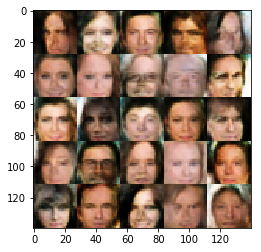

Epoch 1/1... Discriminator Loss: 1.0890... Generator Loss: 1.0519
Epoch 1/1... Discriminator Loss: 0.7479... Generator Loss: 1.8283
Epoch 1/1... Discriminator Loss: 0.9705... Generator Loss: 1.1254
Epoch 1/1... Discriminator Loss: 0.9207... Generator Loss: 1.5868
Epoch 1/1... Discriminator Loss: 0.7862... Generator Loss: 1.4113
Epoch 1/1... Discriminator Loss: 0.6440... Generator Loss: 1.7865
Epoch 1/1... Discriminator Loss: 0.8801... Generator Loss: 0.8717
Epoch 1/1... Discriminator Loss: 0.8067... Generator Loss: 1.5397
Epoch 1/1... Discriminator Loss: 0.9580... Generator Loss: 1.6899
Epoch 1/1... Discriminator Loss: 0.8131... Generator Loss: 1.5190


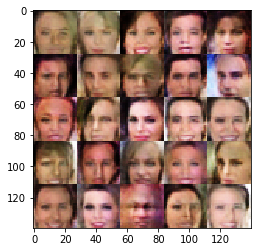

Epoch 1/1... Discriminator Loss: 0.9857... Generator Loss: 1.0983
Epoch 1/1... Discriminator Loss: 0.8963... Generator Loss: 2.4914
Epoch 1/1... Discriminator Loss: 1.1470... Generator Loss: 0.7853
Epoch 1/1... Discriminator Loss: 0.8368... Generator Loss: 1.6521
Epoch 1/1... Discriminator Loss: 0.8168... Generator Loss: 1.5122
Epoch 1/1... Discriminator Loss: 0.8673... Generator Loss: 1.4183
Epoch 1/1... Discriminator Loss: 0.6251... Generator Loss: 1.9951
Epoch 1/1... Discriminator Loss: 0.8202... Generator Loss: 1.3911
Epoch 1/1... Discriminator Loss: 0.9312... Generator Loss: 0.9505
Epoch 1/1... Discriminator Loss: 0.6946... Generator Loss: 2.0389


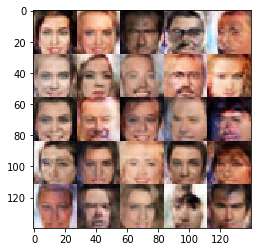

Epoch 1/1... Discriminator Loss: 0.7336... Generator Loss: 1.7622
Epoch 1/1... Discriminator Loss: 0.8744... Generator Loss: 1.2138
Epoch 1/1... Discriminator Loss: 0.7468... Generator Loss: 1.5291
Epoch 1/1... Discriminator Loss: 1.0923... Generator Loss: 1.1022
Epoch 1/1... Discriminator Loss: 0.9079... Generator Loss: 1.6490
Epoch 1/1... Discriminator Loss: 0.9953... Generator Loss: 1.0896
Epoch 1/1... Discriminator Loss: 0.7751... Generator Loss: 1.8519
Epoch 1/1... Discriminator Loss: 0.9216... Generator Loss: 2.3611
Epoch 1/1... Discriminator Loss: 0.8000... Generator Loss: 1.5429
Epoch 1/1... Discriminator Loss: 0.7296... Generator Loss: 1.2558


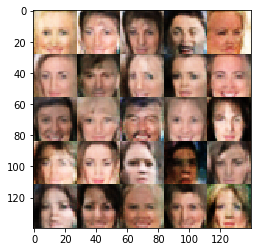

Epoch 1/1... Discriminator Loss: 1.0711... Generator Loss: 0.9530
Epoch 1/1... Discriminator Loss: 0.9200... Generator Loss: 1.4645
Epoch 1/1... Discriminator Loss: 1.2115... Generator Loss: 0.8306
Epoch 1/1... Discriminator Loss: 0.9764... Generator Loss: 1.2538
Epoch 1/1... Discriminator Loss: 0.8960... Generator Loss: 1.4808
Epoch 1/1... Discriminator Loss: 1.1413... Generator Loss: 0.8492
Epoch 1/1... Discriminator Loss: 0.8573... Generator Loss: 1.2982
Epoch 1/1... Discriminator Loss: 1.2700... Generator Loss: 1.0491
Epoch 1/1... Discriminator Loss: 0.8159... Generator Loss: 1.9325
Epoch 1/1... Discriminator Loss: 0.9040... Generator Loss: 1.5487


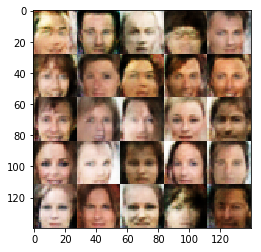

Epoch 1/1... Discriminator Loss: 1.2008... Generator Loss: 0.7387
Epoch 1/1... Discriminator Loss: 1.2410... Generator Loss: 0.9308
Epoch 1/1... Discriminator Loss: 1.2897... Generator Loss: 0.9076
Epoch 1/1... Discriminator Loss: 0.9800... Generator Loss: 1.5221
Epoch 1/1... Discriminator Loss: 0.8843... Generator Loss: 1.2829
Epoch 1/1... Discriminator Loss: 0.6365... Generator Loss: 1.8091
Epoch 1/1... Discriminator Loss: 0.5780... Generator Loss: 2.5002
Epoch 1/1... Discriminator Loss: 0.8603... Generator Loss: 1.4924
Epoch 1/1... Discriminator Loss: 0.7675... Generator Loss: 1.5974
Epoch 1/1... Discriminator Loss: 0.6016... Generator Loss: 1.8568


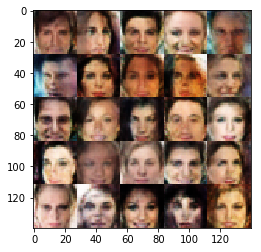

Epoch 1/1... Discriminator Loss: 1.5983... Generator Loss: 0.4568
Epoch 1/1... Discriminator Loss: 1.1906... Generator Loss: 0.8242
Epoch 1/1... Discriminator Loss: 0.7709... Generator Loss: 1.9201
Epoch 1/1... Discriminator Loss: 0.8868... Generator Loss: 2.1277
Epoch 1/1... Discriminator Loss: 0.8858... Generator Loss: 1.1694
Epoch 1/1... Discriminator Loss: 0.7101... Generator Loss: 2.1977
Epoch 1/1... Discriminator Loss: 0.7007... Generator Loss: 2.1950
Epoch 1/1... Discriminator Loss: 0.7812... Generator Loss: 2.0139
Epoch 1/1... Discriminator Loss: 0.7309... Generator Loss: 2.0179
Epoch 1/1... Discriminator Loss: 0.6598... Generator Loss: 1.7367


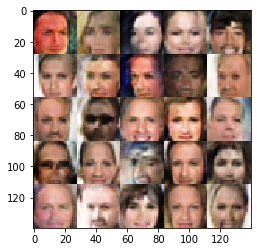

Epoch 1/1... Discriminator Loss: 0.7518... Generator Loss: 1.5059
Epoch 1/1... Discriminator Loss: 0.6792... Generator Loss: 1.9529
Epoch 1/1... Discriminator Loss: 0.9484... Generator Loss: 0.9536
Epoch 1/1... Discriminator Loss: 0.9388... Generator Loss: 1.3505
Epoch 1/1... Discriminator Loss: 1.1872... Generator Loss: 1.0105
Epoch 1/1... Discriminator Loss: 0.7951... Generator Loss: 1.2692
Epoch 1/1... Discriminator Loss: 0.7139... Generator Loss: 1.4721
Epoch 1/1... Discriminator Loss: 1.0010... Generator Loss: 1.1162
Epoch 1/1... Discriminator Loss: 1.0447... Generator Loss: 0.9612
Epoch 1/1... Discriminator Loss: 1.1121... Generator Loss: 0.8826


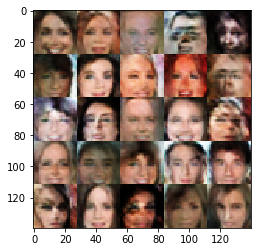

Epoch 1/1... Discriminator Loss: 0.6414... Generator Loss: 2.2051
Epoch 1/1... Discriminator Loss: 0.9830... Generator Loss: 1.0447
Epoch 1/1... Discriminator Loss: 0.7784... Generator Loss: 1.6518
Epoch 1/1... Discriminator Loss: 0.6780... Generator Loss: 1.6723
Epoch 1/1... Discriminator Loss: 1.0323... Generator Loss: 1.6019
Epoch 1/1... Discriminator Loss: 0.6562... Generator Loss: 2.1905
Epoch 1/1... Discriminator Loss: 1.1570... Generator Loss: 0.8709
Epoch 1/1... Discriminator Loss: 0.9253... Generator Loss: 1.5616
Epoch 1/1... Discriminator Loss: 0.9251... Generator Loss: 1.4168
Epoch 1/1... Discriminator Loss: 0.6178... Generator Loss: 2.2844


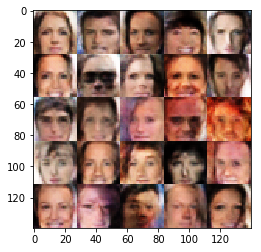

Epoch 1/1... Discriminator Loss: 0.7420... Generator Loss: 2.3459
Epoch 1/1... Discriminator Loss: 0.6019... Generator Loss: 2.0190
Epoch 1/1... Discriminator Loss: 0.6202... Generator Loss: 2.4031
Epoch 1/1... Discriminator Loss: 0.7155... Generator Loss: 1.9098
Epoch 1/1... Discriminator Loss: 0.8762... Generator Loss: 1.3038
Epoch 1/1... Discriminator Loss: 0.9102... Generator Loss: 1.0168
Epoch 1/1... Discriminator Loss: 0.8929... Generator Loss: 1.3668
Epoch 1/1... Discriminator Loss: 0.8180... Generator Loss: 1.1901
Epoch 1/1... Discriminator Loss: 1.2766... Generator Loss: 0.8917
Epoch 1/1... Discriminator Loss: 1.1250... Generator Loss: 0.9333


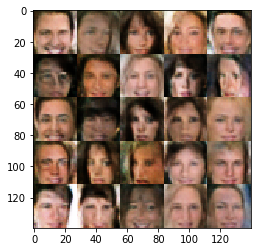

Epoch 1/1... Discriminator Loss: 0.9405... Generator Loss: 1.1417
Epoch 1/1... Discriminator Loss: 0.8182... Generator Loss: 1.6548
Epoch 1/1... Discriminator Loss: 1.1727... Generator Loss: 0.7188
Epoch 1/1... Discriminator Loss: 0.9781... Generator Loss: 1.9888
Epoch 1/1... Discriminator Loss: 0.7000... Generator Loss: 1.7111
Epoch 1/1... Discriminator Loss: 0.8940... Generator Loss: 1.1191
Epoch 1/1... Discriminator Loss: 0.8037... Generator Loss: 1.3487
Epoch 1/1... Discriminator Loss: 0.7160... Generator Loss: 1.5314
Epoch 1/1... Discriminator Loss: 1.0082... Generator Loss: 1.0523
Epoch 1/1... Discriminator Loss: 0.7175... Generator Loss: 1.3046


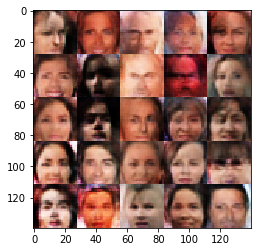

Epoch 1/1... Discriminator Loss: 1.1103... Generator Loss: 1.2770
Epoch 1/1... Discriminator Loss: 0.9439... Generator Loss: 1.3072
Epoch 1/1... Discriminator Loss: 0.8473... Generator Loss: 1.7786
Epoch 1/1... Discriminator Loss: 0.7494... Generator Loss: 1.5425
Epoch 1/1... Discriminator Loss: 0.6111... Generator Loss: 2.2846
Epoch 1/1... Discriminator Loss: 0.7661... Generator Loss: 1.7786
Epoch 1/1... Discriminator Loss: 0.8173... Generator Loss: 1.6106
Epoch 1/1... Discriminator Loss: 0.6533... Generator Loss: 1.9473
Epoch 1/1... Discriminator Loss: 0.6802... Generator Loss: 1.8640
Epoch 1/1... Discriminator Loss: 0.9475... Generator Loss: 1.2778


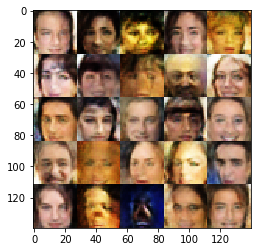

Epoch 1/1... Discriminator Loss: 1.0287... Generator Loss: 1.3694
Epoch 1/1... Discriminator Loss: 0.8277... Generator Loss: 1.4181
Epoch 1/1... Discriminator Loss: 0.7654... Generator Loss: 1.6404
Epoch 1/1... Discriminator Loss: 0.7401... Generator Loss: 1.2923
Epoch 1/1... Discriminator Loss: 1.0949... Generator Loss: 1.1104
Epoch 1/1... Discriminator Loss: 0.9523... Generator Loss: 1.1417
Epoch 1/1... Discriminator Loss: 0.6131... Generator Loss: 1.9701
Epoch 1/1... Discriminator Loss: 0.7426... Generator Loss: 2.4031
Epoch 1/1... Discriminator Loss: 1.1058... Generator Loss: 0.9691
Epoch 1/1... Discriminator Loss: 0.9850... Generator Loss: 0.8865


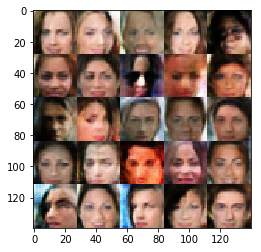

Epoch 1/1... Discriminator Loss: 0.5977... Generator Loss: 2.7154
Epoch 1/1... Discriminator Loss: 1.0784... Generator Loss: 2.2506
Epoch 1/1... Discriminator Loss: 0.8166... Generator Loss: 1.1990


In [14]:
batch_size = 32
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.